In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#this is downloading the data
Bedforms = pd.read_csv('data/BedformData.csv')
y = Bedforms['Y/N'] #results data that will be used to compare to the trained output
X = Bedforms[['Topo', 'Bed', 'Elong', 'Area']] #input data that will be used to train the results

In [3]:
#we are changing all string inputs to binarized integers so they can be processed by the model.
X.loc[X['Topo'] == 'O', 'Topo'] = 1
X.loc[X['Topo'] == 'V', 'Topo'] = 0

X.loc[X['Bed'] == 'C', 'Bed'] = 1
X.loc[X['Bed'] == 'S', 'Bed'] = 0

In [4]:
X.dtypes

Topo      object
Bed       object
Elong    float64
Area     float64
dtype: object

In [5]:
X['Topo'] = X['Topo'].astype('int8') #change all columns of the input dataset to integers from string
X['Bed'] = X['Bed'].astype('int8')

/tmp/ipykernel_120/346836708.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Topo'] = X['Topo'].astype('int8') #change all columns of the input dataset to integers from string
/tmp/ipykernel_120/346836708.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Bed'] = X['Bed'].astype('int8')


In [6]:
X.dtypes

Topo        int8
Bed         int8
Elong    float64
Area     float64
dtype: object

In [7]:
from sklearn.ensemble import RandomForestClassifier

In [46]:
#adding controls to get a better fit
#n_estimators - how many "trees" are in the "forest", default was 100 making it wider to 1000 is approx 2%, increasing testing tuning
#min_samples_leaf - control of number of times it runs-- average of more runs, changing from 8 to 50
#random_state - reproducibility, not the modeling or stats aspect
rf_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=5, min_samples_split=150, random_state=42, n_jobs=-1) #using all 4 cpus
rf_model.fit(X, y)

RandomForestClassifier(min_samples_leaf=5, min_samples_split=150, n_jobs=-1,
                       random_state=42)

In [47]:
#find random selection of the data to test the model, try using 10% 
#these are the same rows for X and y because of random_state bits chosing the same columns (this is how it can be reproduced)
X_test = X.sample(frac = 0.2, random_state=42)
y_test = y.sample(frac = 0.2, random_state=42)

In [48]:
y_est = rf_model.predict(X_test) #same this as saying y_pred

In [49]:
y_pred_prob = rf_model.predict_proba(X)

In [50]:
y_pred_prob

array([[0.87358877, 0.12641123],
       [0.93615762, 0.06384238],
       [0.96530438, 0.03469562],
       ...,
       [0.91945091, 0.08054909],
       [0.90223222, 0.09776778],
       [0.66912936, 0.33087064]])

In [51]:
#using the 10% of data we selected, we're determining how many predictions are right out of the number it makes
import matplotlib.pyplot as plt
print(f'Prediction Count: {len(y_est)}')
print(f'Correct Predictions: {len(y_est[y_est == y_test])}')

Prediction Count: 117159
Correct Predictions: 114308


In [52]:
#calculate the percentage of correct predictions out of total predictions for 10% random data selection
114308/117159

0.9756655485280686

In [8]:
#cross-validate a grid, it'll run all options and determine the best one
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [8]:
#coarse-grid validation
param_grid = {
    'max_features': ['sqrt'],
    'min_samples_leaf': [2, 5, 10],
    'min_samples_split': [5, 10, 25, 50, 75, 100],
    'n_estimators': [100, 500, 1000, 2500]}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid,
                           cv=KFold(n_splits=5, shuffle=True, random_state=42), verbose=2) #changing when it updates me

grid_search.fit(X, y)

#after this, depending on the best fit, we will run a higher resolution grid validation

In [7]:
import joblib
joblib.dump(grid_search.best_estimator_, 'RandomForest.pkl')

['RandomForest.pkl']

In [9]:
grid_search.best_estimator_

RandomForestClassifier(min_samples_leaf=5, min_samples_split=100,
                       random_state=42)

In [3]:
import joblib
grid_search = joblib.load('RandomForest.pkl')
grid_search.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 100,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [9]:
#cross-validate a grid, it'll run all options and determine the best one
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
#coarse-grid validation
param_grid = {
    'max_features': ['sqrt'],
    'min_samples_leaf': [2, 5, 10],
    'min_samples_split': [100, 150, 200, 500],
    'n_estimators': [10, 50, 75, 100]}
grid_search_small = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid,
                           cv=KFold(n_splits=5, shuffle=True, random_state=42), verbose=2) #changing when it updates me

grid_search_small.fit(X, y)

#after this, depending on the best fit, we will run a higher resolution grid validation

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END max_features=sqrt, min_samples_leaf=2, min_samples_split=100, n_estimators=10; total time=   3.7s
[CV] END max_features=sqrt, min_samples_leaf=2, min_samples_split=100, n_estimators=10; total time=   3.8s
[CV] END max_features=sqrt, min_samples_leaf=2, min_samples_split=100, n_estimators=10; total time=   3.6s
[CV] END max_features=sqrt, min_samples_leaf=2, min_samples_split=100, n_estimators=10; total time=   3.5s
[CV] END max_features=sqrt, min_samples_leaf=2, min_samples_split=100, n_estimators=10; total time=   3.8s
[CV] END max_features=sqrt, min_samples_leaf=2, min_samples_split=100, n_estimators=50; total time=  17.8s
[CV] END max_features=sqrt, min_samples_leaf=2, min_samples_split=100, n_estimators=50; total time=  17.9s
[CV] END max_features=sqrt, min_samples_leaf=2, min_samples_split=100, n_estimators=50; total time=  17.8s
[CV] END max_features=sqrt, min_samples_leaf=2, min_samples_split=100, n_estimator

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_features': ['sqrt'],
                         'min_samples_leaf': [2, 5, 10],
                         'min_samples_split': [100, 150, 200, 500],
                         'n_estimators': [10, 50, 75, 100]},
             verbose=2)

In [11]:
import joblib
joblib.dump(grid_search_small.best_estimator_, 'RandomForest_small.pkl')

['RandomForest_small.pkl']

In [12]:
grid_search_small = joblib.load('RandomForest_small.pkl')
grid_search_small.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 150,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [ ]:
#find random selection of the data to test the model, try using 10% 
#these are the same rows for X and y because of random_state bits chosing the same columns (this is how it can be reproduced)
X_test = X.sample(frac = 0.2, random_state=42)
y_test = y.sample(frac = 0.2, random_state=42)

In [ ]:
y_est = rf_model.predict(X_test) #same this as saying y_pred

In [ ]:
#using the 10% of data we selected, we're determining how many predictions are right out of the number it makes
import matplotlib.pyplot as plt
print(f'Prediction Count: {len(y_est)}')
print(f'Correct Predictions: {len(y_est[y_est == y_test])}')

### Optimize True Positive Detection

Now we'll cross-validate using the F1 score, which should help with calculating our true positives.

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score

In [14]:
# Define the parameter grid
param_grid = {
    'max_features': ['sqrt'],
    'min_samples_leaf': [2, 5, 10],
    'min_samples_split': [100, 150, 200, 500],
    'n_estimators': [10, 50, 75, 100]
}

In [15]:
# Define scoring metrics
scoring = {
    'f1_score': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score)
}

In [16]:
# Initialize GridSearchCV
grid_search_small = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring=scoring,
    refit='f1_score',  # Refit to F1 score
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    verbose=2
)

In [17]:
# Fit the grid search
grid_search_small.fit(X, y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END max_features=sqrt, min_samples_leaf=2, min_samples_split=100, n_estimators=10; total time=   3.3s
[CV] END max_features=sqrt, min_samples_leaf=2, min_samples_split=100, n_estimators=10; total time=   3.4s
[CV] END max_features=sqrt, min_samples_leaf=2, min_samples_split=100, n_estimators=10; total time=   3.1s
[CV] END max_features=sqrt, min_samples_leaf=2, min_samples_split=100, n_estimators=10; total time=   3.2s
[CV] END max_features=sqrt, min_samples_leaf=2, min_samples_split=100, n_estimators=10; total time=   3.3s
[CV] END max_features=sqrt, min_samples_leaf=2, min_samples_split=100, n_estimators=50; total time=  15.4s
[CV] END max_features=sqrt, min_samples_leaf=2, min_samples_split=100, n_estimators=50; total time=  15.6s
[CV] END max_features=sqrt, min_samples_leaf=2, min_samples_split=100, n_estimators=50; total time=  15.5s
[CV] END max_features=sqrt, min_samples_leaf=2, min_samples_split=100, n_estimator

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_features': ['sqrt'],
                         'min_samples_leaf': [2, 5, 10],
                         'min_samples_split': [100, 150, 200, 500],
                         'n_estimators': [10, 50, 75, 100]},
             refit='f1_score',
             scoring={'f1_score': make_scorer(f1_score, response_method='predict'),
                      'precision': make_scorer(precision_score, response_method='predict'),
                      'recall': make_scorer(recall_score, response_method='predict')},
             verbose=2)

In [18]:
# Best parameters
print("Best parameters:", grid_search_small.best_params_)

# Best scores based on the prioritized metric (F1 score) and others
print("Best F1 score:", grid_search_small.best_score_)
print("Best Precision score:", grid_search_small.cv_results_['mean_test_precision'][grid_search_small.best_index_])
print("Best Recall score:", grid_search_small.cv_results_['mean_test_recall'][grid_search_small.best_index_])

Best parameters: {'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 100, 'n_estimators': 10}
Best F1 score: 0.2092902127945297
Best Precision score: 0.6676010927089733
Best Recall score: 0.12412059961224467


Okay, so CV isn't doing great on the minimum class. Let's first try weighting to see what we get.

In [19]:
rf_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=5, 
                                  min_samples_split=150, random_state=42,
                                  class_weight='balanced',
                                  n_jobs=-1) 
rf_model.fit(X, y)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=5,
                       min_samples_split=150, n_jobs=-1, random_state=42)

In [20]:
y_pred = rf_model.predict(X)

In [21]:
# Calculate precision
precision = precision_score(y, y_pred)

# Calculate recall
recall = recall_score(y, y_pred)

# Calculate F1 score
f1 = f1_score(y, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.12002262879771655
Recall: 0.5968670076726342
F1 Score: 0.1998565571576908


Balanced overdoes it. Let's see what we can do. I'll try to set it to inverse class frequency.

In [24]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights based on inverse class frequency
class_labels = np.unique(y)  
class_weights = compute_class_weight('balanced', classes=class_labels, y=y)

# Create a dictionary mapping class labels to class weights
class_weights_dict = dict(zip(class_labels, class_weights))

print("Class Weights:", class_weights_dict)

Class Weights: {0: 0.5137155445176408, 1: 18.727493606138108}


In [25]:
rf_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=5, 
                                  min_samples_split=150, random_state=42,
                                  class_weight=class_weights_dict,
                                  n_jobs=-1) 
rf_model.fit(X, y)

RandomForestClassifier(class_weight={0: 0.5137155445176408,
                                     1: 18.727493606138108},
                       min_samples_leaf=5, min_samples_split=150, n_jobs=-1,
                       random_state=42)

In [26]:
y_pred = rf_model.predict(X)

In [27]:
# Calculate precision
precision = precision_score(y, y_pred)

# Calculate recall
recall = recall_score(y, y_pred)

# Calculate F1 score
f1 = f1_score(y, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.12002262879771655
Recall: 0.5968670076726342
F1 Score: 0.1998565571576908


Okay, at least we've proved how it's finding the weights. I think we might need to artificially sample down the overrepresented class.

In [99]:
from collections import Counter

def random_undersample(X, y, undersample_proportion):
    # Combine features and labels
    data = np.column_stack((X, y))

    # Determine the class with fewer instances
    counter = Counter(y)
    minority_class = min(counter, key=counter.get)
    majority_class = max(counter, key=counter.get)

    # Calculate the number of instances to undersample based on the proportion
    undersample_size = int(counter[majority_class] * undersample_proportion)

    # Get indices of instances belonging to the majority class
    majority_indices = np.where(y == majority_class)[0]

    # Randomly select indices from the majority class equal to the undersample size
    undersampled_indices = np.random.choice(majority_indices, size=undersample_size, replace=False)

    # Select all instances of minority class
    minority_indices = np.where(y == minority_class)[0]

    # Combine undersampled majority class with minority class
    undersampled_data = np.vstack((data[undersampled_indices], data[minority_indices]))

    # Shuffle the data
    np.random.shuffle(undersampled_data)

    # Separate features and labels
    X_undersampled = undersampled_data[:, :-1]
    y_undersampled = undersampled_data[:, -1]
    
    # Convert X_undersampled back to DataFrame with original column names
    X_undersampled_df = pd.DataFrame(X_undersampled, columns=X.columns)
    
    return X_undersampled_df, y_undersampled

In [100]:
ratio=len(y[y==1])/len(y[y==0])

In [101]:
X_undersampled, y_undersampled = random_undersample(X, y, ratio)

In [102]:
rf_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=5, 
                                  min_samples_split=150, random_state=42,
                                  class_weight='balanced',
                                  n_jobs=-1) 

In [103]:
rf_model.fit(X_undersampled, y_undersampled)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=5,
                       min_samples_split=150, n_jobs=-1, random_state=42)

In [104]:
y_pred = rf_model.predict(X)

In [105]:
# Calculate precision
accuracy = accuracy_score(y, y_pred)

# Calculate precision
precision = precision_score(y, y_pred)

# Calculate recall
recall = recall_score(y, y_pred)

# Calculate F1 score
f1 = f1_score(y, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8612127771442618
Precision: 0.10979711660743786
Recall: 0.5906649616368287
F1 Score: 0.18517293564649168


Okay, I need to do a much better job of sampling downwards. Let's look at some distributions.

In [106]:
print(len(X))
print(len(X_undersampled))

585796
31280


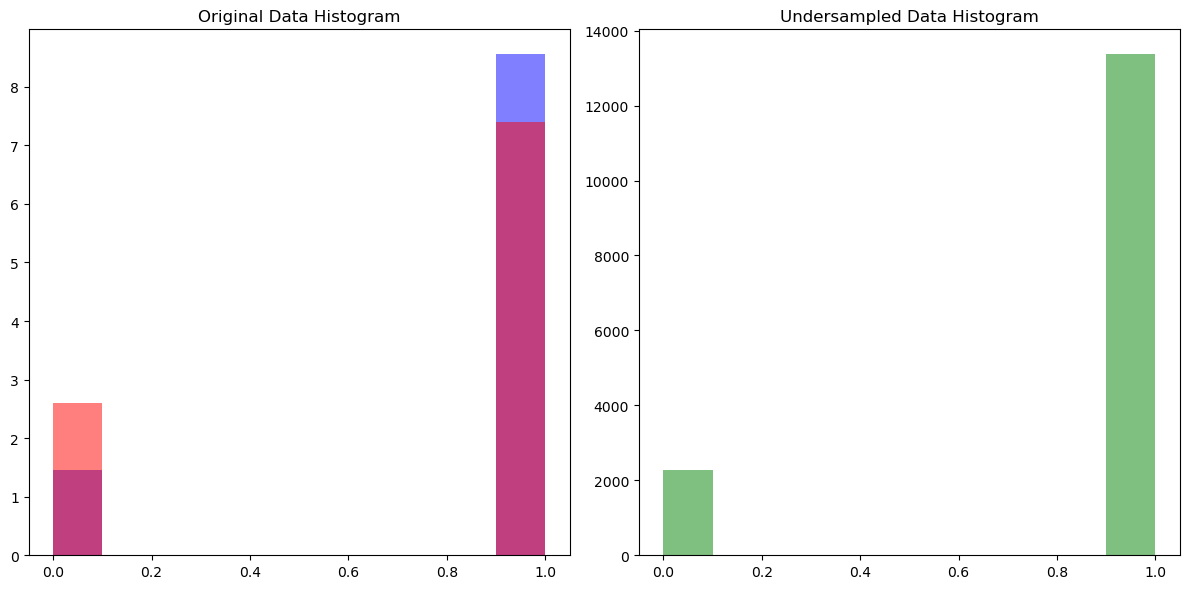

In [131]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].hist(X['Topo'][y == 0], bins=10, color='blue', density=True,
            alpha=0.5, label='Original Data')
axs[0].hist(X['Topo'][y == 1], bins=10, color='red', density=True,
            alpha=0.5, label='Original Data')
axs[1].hist(X_undersampled['Topo'][y_undersampled == 0], bins=10, color='green', alpha=0.5, label='Undersampled Data')

axs[0].set_title('Original Data Histogram')
axs[1].set_title('Undersampled Data Histogram')

plt.tight_layout()

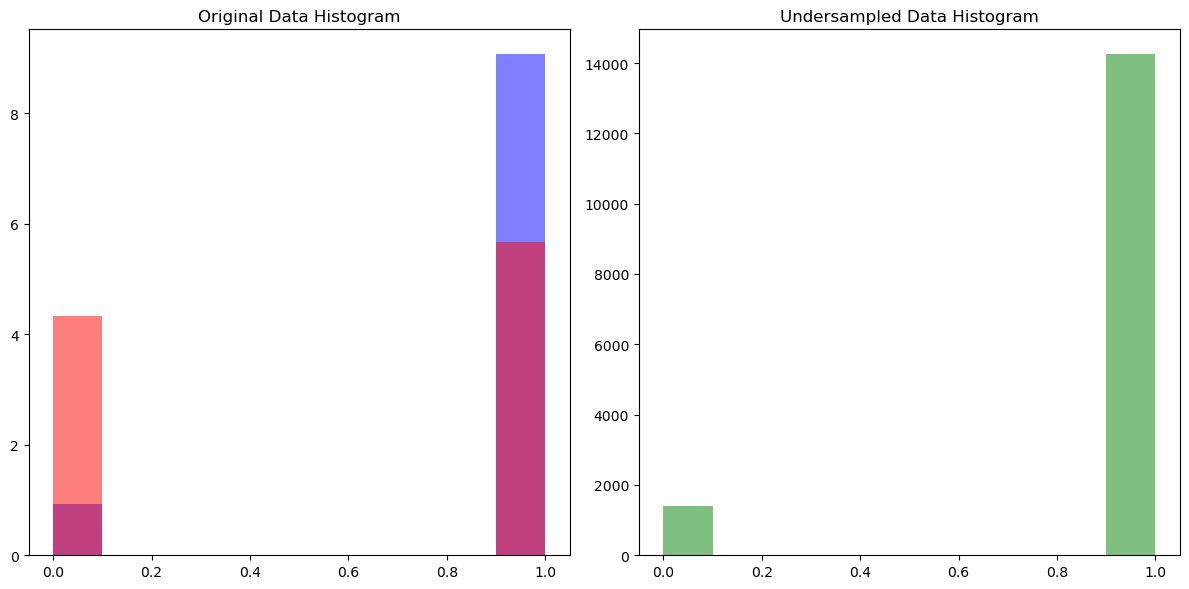

In [130]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].hist(X['Bed'][y == 0], bins=10, color='blue', density=True,
            alpha=0.5, label='Original Data')
axs[0].hist(X['Bed'][y == 1], bins=10, color='red', density=True,
            alpha=0.5, label='Original Data')
axs[1].hist(X_undersampled['Bed'][y_undersampled == 0], bins=10, color='green', alpha=0.5, label='Undersampled Data')

axs[0].set_title('Original Data Histogram')
axs[1].set_title('Undersampled Data Histogram')

plt.tight_layout()

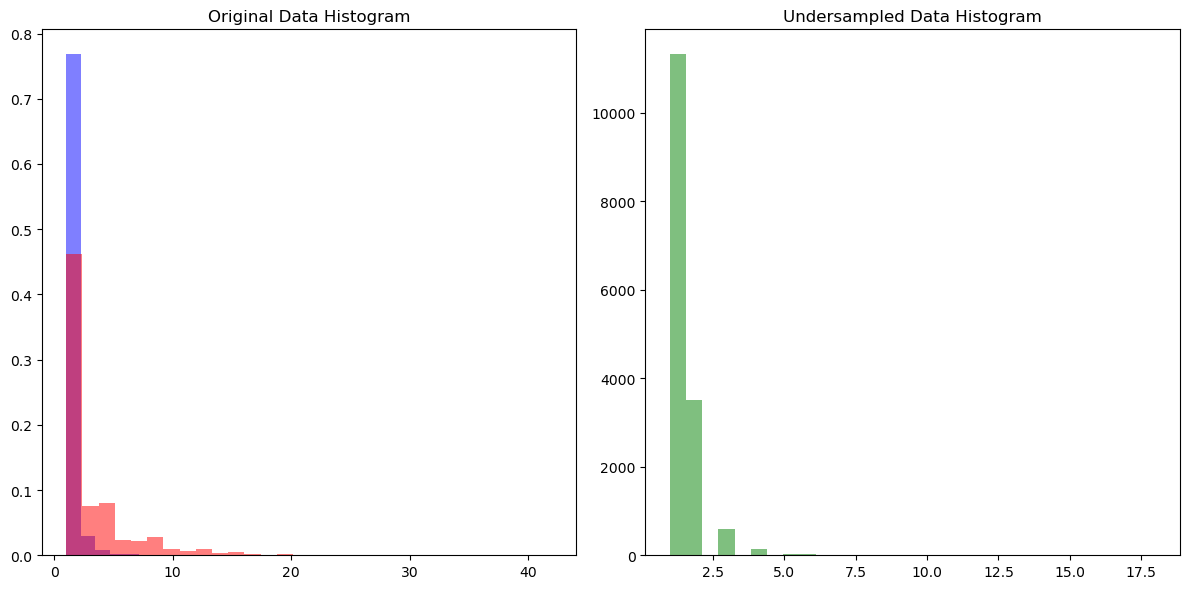

In [114]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].hist(X['Elong'][y == 0], bins=30, color='blue', density=True,
            alpha=0.5, label='Original Data')
axs[0].hist(X['Elong'][y == 1], bins=30, color='red', density=True,
            alpha=0.5, label='Original Data')
axs[1].hist(X_undersampled['Elong'][y_undersampled == 0], bins=30, color='green', alpha=0.5, label='Undersampled Data')

axs[0].set_title('Original Data Histogram')
axs[1].set_title('Undersampled Data Histogram')

plt.tight_layout();

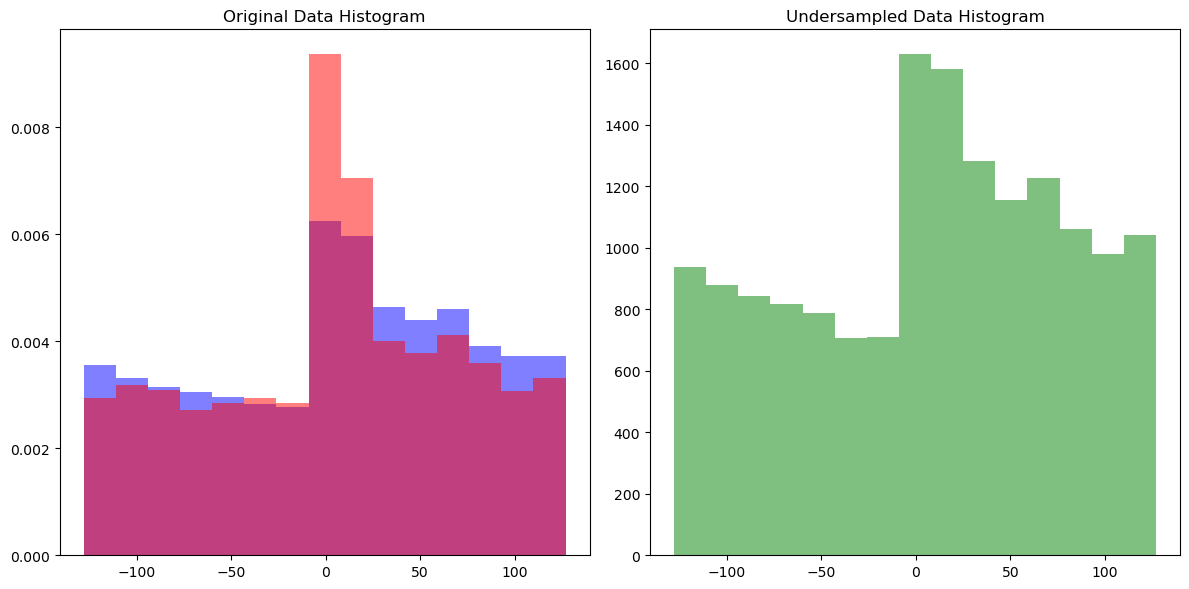

In [112]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].hist(X['Area'][y == 0], bins=15, color='blue', density=True,
            alpha=0.5, label='Original Data')
axs[0].hist(X['Area'][y == 1], bins=15, color='red', density=True,
            alpha=0.5, label='Original Data')
axs[1].hist(X_undersampled['Area'][y_undersampled == 0], bins=15, color='green', alpha=0.5, label='Undersampled Data')

axs[0].set_title('Original Data Histogram')
axs[1].set_title('Undersampled Data Histogram')

plt.tight_layout();

The distributions are very similar. Let's try some specialty imbalanced classifier methods.

In [100]:
pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 3.4 MB/s eta 0:00:00:00:01
Note: you may need to restart the kernel to use updated packages.


In [101]:
from imblearn.ensemble import EasyEnsembleClassifier

In [102]:
rf_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=5, 
                                  min_samples_split=150, random_state=42, 
                                  n_jobs=-1) 

In [110]:
eec_model = EasyEnsembleClassifier(n_estimators=100, sampling_strategy=1.0,
                                   replacement=False, n_jobs=-1,
                                   random_state=18)

In [111]:
eec_model.fit(X, y)

EasyEnsembleClassifier(n_estimators=100, n_jobs=-1, random_state=18,
                       sampling_strategy=1.0)

In [112]:
y_pred = eec_model.predict(X)

In [113]:
# Calculate precision
accuracy = accuracy_score(y, y_pred)

# Calculate precision
precision = precision_score(y, y_pred)

# Calculate recall
recall = recall_score(y, y_pred)

# Calculate F1 score
f1 = f1_score(y, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8551031417080349
Precision: 0.10524515393386545
Recall: 0.590153452685422
F1 Score: 0.1786336365395781


Okay, I potentially need to do a grid search now to find the best option for this one. I'm going to write a grid search for this eec.

In [122]:
param_grid = {
    'n_estimators': [10, 50, 100, 150, 200],            
    'sampling_strategy': ['auto', 'majority', 1.0],  
    'replacement': [True, False],     
}

In [123]:
# Define scoring metrics
scoring = {
    'f1_score': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score)
}

In [124]:
# Initialize GridSearchCV
grid_search_eec = GridSearchCV(
    estimator=EasyEnsembleClassifier(random_state=42),
    param_grid=param_grid,
    scoring=scoring,
    refit='f1_score',  # Refit to F1 score
    cv=5,  # Number of cross-validation folds
    verbose=2
)

In [125]:
# Perform grid search
grid_search_eec.fit(X, y)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END n_estimators=10, replacement=True, sampling_strategy=auto; total time=   5.1s
[CV] END n_estimators=10, replacement=True, sampling_strategy=auto; total time=   5.1s
[CV] END n_estimators=10, replacement=True, sampling_strategy=auto; total time=   5.2s
[CV] END n_estimators=10, replacement=True, sampling_strategy=auto; total time=   5.1s
[CV] END n_estimators=10, replacement=True, sampling_strategy=auto; total time=   5.1s
[CV] END n_estimators=10, replacement=True, sampling_strategy=majority; total time=   5.1s
[CV] END n_estimators=10, replacement=True, sampling_strategy=majority; total time=   5.0s
[CV] END n_estimators=10, replacement=True, sampling_strategy=majority; total time=   5.1s
[CV] END n_estimators=10, replacement=True, sampling_strategy=majority; total time=   5.1s
[CV] END n_estimators=10, replacement=True, sampling_strategy=majority; total time=   5.1s
[CV] END n_estimators=10, replacement=True, samp

GridSearchCV(cv=5, estimator=EasyEnsembleClassifier(random_state=42),
             param_grid={'n_estimators': [10, 50, 100, 150, 200],
                         'replacement': [True, False],
                         'sampling_strategy': ['auto', 'majority', 1.0]},
             refit='f1_score',
             scoring={'f1_score': make_scorer(f1_score, response_method='predict'),
                      'precision': make_scorer(precision_score, response_method='predict'),
                      'recall': make_scorer(recall_score, response_method='predict')},
             verbose=2)

In [126]:
# Best parameters
print("Best parameters:", grid_search_eec.best_params_)

# Best scores based on the prioritized metric (F1 score) and others
print("Best F1 score:", grid_search_eec.best_score_)
print("Best Precision score:", grid_search_eec.cv_results_['mean_test_precision'][grid_search_small.best_index_])
print("Best Recall score:", grid_search_eec.cv_results_['mean_test_recall'][grid_search_small.best_index_])

Best parameters: {'n_estimators': 10, 'replacement': True, 'sampling_strategy': 'auto'}
Best F1 score: 0.19212572563724156
Best Precision score: 0.13676662173831064
Best Recall score: 0.5456521739130435


In [128]:
y_pred = best_estimator = grid_search_eec.best_estimator_.predict(X)

In [10]:
from sklearn.metrics import confusion_matrix

In [130]:
conf_matrix = confusion_matrix(y, y_pred)

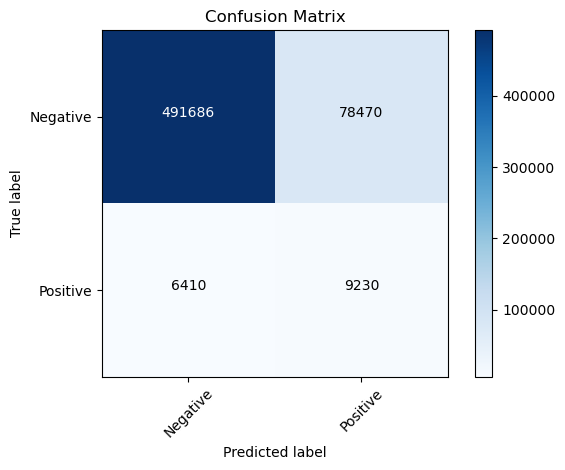

In [131]:
# Plot confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels
classes = ['Negative', 'Positive']  # Assuming class names
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add text annotations
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

### SMOTE oversampling

We're still not reaching the ideal using ensemble methods developed for class imbalance, so we'll try some other things, like SMOTE and ADASYN oversampling, because all we're doing now is overpredicting and hopefully this will help.

In [11]:
X = X[['Bed','Elong','Area']]

In [133]:
from imblearn.over_sampling import SMOTE

In [134]:
# Initialize SMOTE
smote = SMOTE(sampling_strategy=1.0, k_neighbors=30)

In [135]:
# Apply SMOTE to generate synthetic samples
X_resampled, y_resampled = smote.fit_resample(X, y)

In [136]:
len(y_resampled[y_resampled==1])

570156

At some point, look at the distributions to make sure that those have been preserved.

In [137]:
rf_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=5, 
                                  min_samples_split=150, random_state=42, 
                                  n_jobs=-1) 
rf_model.fit(X_resampled, y_resampled)

RandomForestClassifier(min_samples_leaf=5, min_samples_split=150, n_jobs=-1,
                       random_state=42)

In [138]:
y_pred = rf_model.predict(X)

In [139]:
# Calculate precision
accuracy = accuracy_score(y, y_pred)

# Calculate precision
precision = precision_score(y, y_pred)

# Calculate recall
recall = recall_score(y, y_pred)

# Calculate F1 score
f1 = f1_score(y, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8808117501655867
Precision: 0.12347806749318953
Recall: 0.5680306905370844
F1 Score: 0.2028588391103804


In [140]:
conf_matrix = confusion_matrix(y, y_pred)

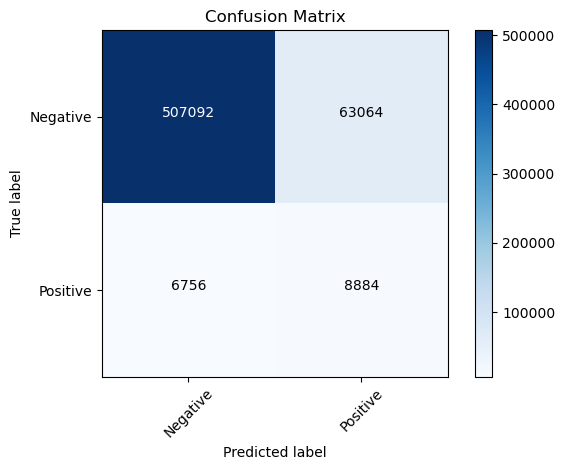

In [141]:
# Plot confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels
classes = ['Negative', 'Positive']  # Assuming class names
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add text annotations
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

Next, try alternatives to SMOTE. SMOTEN is made for categorical data, but from below doesn't seem to work better.

In [211]:
from imblearn.over_sampling import SMOTEN

In [219]:
smoten = SMOTEN(sampling_strategy=1.0)

In [220]:
X_resampled, y_resampled = smoten.fit_resample(X, y)

In [221]:
rf_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=5, 
                                  min_samples_split=150, random_state=42, 
                                  n_jobs=-1) 
rf_model.fit(X_resampled, y_resampled)

RandomForestClassifier(min_samples_leaf=5, min_samples_split=150, n_jobs=-1,
                       random_state=42)

In [222]:
y_pred = rf_model.predict(X)

In [223]:
# Calculate precision
accuracy = accuracy_score(y, y_pred)

# Calculate precision
precision = precision_score(y, y_pred)

# Calculate recall
recall = recall_score(y, y_pred)

# Calculate F1 score
f1 = f1_score(y, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8645910863167382
Precision: 0.1056158343242172
Recall: 0.5452046035805627
F1 Score: 0.1769527683240641


In [224]:
conf_matrix = confusion_matrix(y, y_pred)

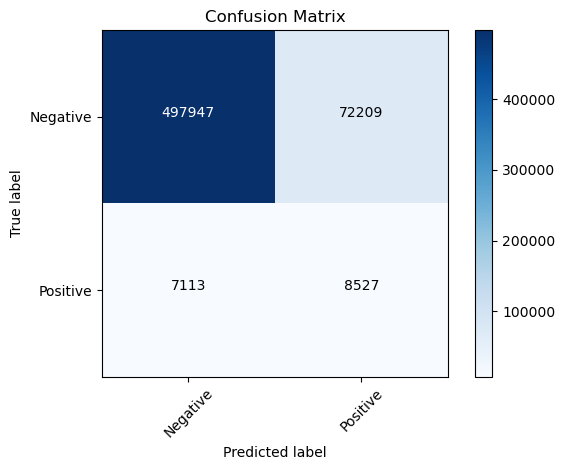

In [225]:
# Plot confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels
classes = ['Negative', 'Positive']  # Assuming class names
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add text annotations
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

Next we'll try ADASYN

In [34]:
from imblearn.over_sampling import ADASYN

In [205]:
ada = ADASYN(sampling_strategy=1, 
             n_neighbors=13,
             random_state=42)

In [206]:
X_resampled, y_resampled = ada.fit_resample(X, y)

In [207]:
rf_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=5, 
                                  min_samples_split=150, random_state=42, 
                                  n_jobs=-1) 
rf_model.fit(X_resampled, y_resampled)

RandomForestClassifier(min_samples_leaf=5, min_samples_split=150, n_jobs=-1,
                       random_state=42)

In [208]:
y_pred = rf_model.predict(X)

In [209]:
# Calculate precision
accuracy = accuracy_score(y, y_pred)

# Calculate precision
precision = precision_score(y, y_pred)

# Calculate recall
recall = recall_score(y, y_pred)

# Calculate F1 score
f1 = f1_score(y, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8695962416950611
Precision: 0.11579812800404755
Recall: 0.5853580562659847
F1 Score: 0.19334741288278776


In [210]:
conf_matrix = confusion_matrix(y, y_pred)

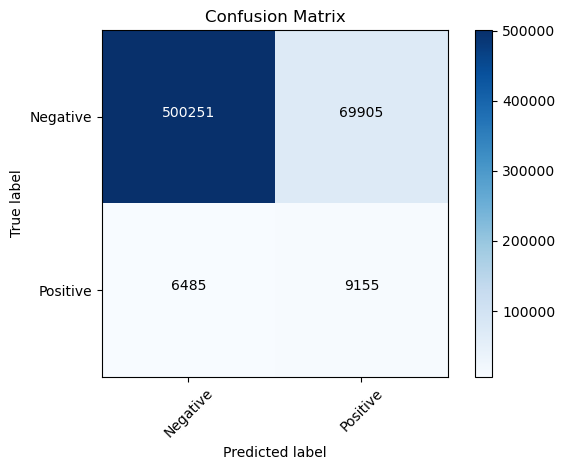

In [211]:
# Plot confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels
classes = ['Negative', 'Positive']  # Assuming class names
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add text annotations
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

Try SVMSMOTE which has been shown to have similar performance as ADASYN on preserving the underrepresented data. As we can see above, ADASYN does the best job on TP, but the tradeoff is a huge amount of FP.

In [12]:
pip install imbalanced-learn

  Using cached imbalanced_learn-0.12.2-py3-none-any.whl.metadata (8.2 kB)
Using cached imbalanced_learn-0.12.2-py3-none-any.whl (257 kB)
Note: you may need to restart the kernel to use updated packages.


In [14]:
from imblearn.over_sampling import SVMSMOTE

In [27]:
svmsmote = SVMSMOTE(k_neighbors=15,
                    m_neighbors=15,
                    random_state=42)

In [28]:
X_resampled, y_resampled = svmsmote.fit_resample(X, y)

In [29]:
rf_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=5, 
                                  min_samples_split=150, random_state=42, 
                                  n_jobs=-1) 
rf_model.fit(X_resampled, y_resampled)

RandomForestClassifier(min_samples_leaf=5, min_samples_split=150, n_jobs=-1,
                       random_state=42)

In [30]:
y_pred = rf_model.predict(X)

In [31]:
# Calculate precision
accuracy = accuracy_score(y, y_pred)

# Calculate precision
precision = precision_score(y, y_pred)

# Calculate recall
recall = recall_score(y, y_pred)

# Calculate F1 score
f1 = f1_score(y, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9300439060696898
Precision: 0.16594600295296352
Recall: 0.4024296675191816
F1 Score: 0.2349910394265233


In [32]:
conf_matrix = confusion_matrix(y, y_pred)

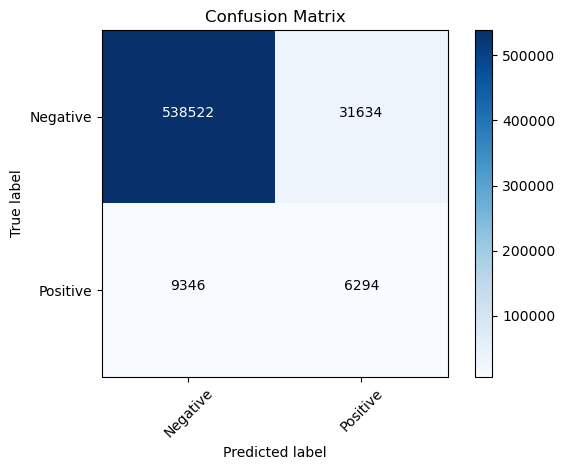

In [33]:
# Plot confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels
classes = ['Negative', 'Positive']  # Assuming class names
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add text annotations
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

ADASYN is working the best for TP, but worst for FP. I'm going to try to tamp this down by balancing with an undersampling method first.

Next let's try to predict probabilities with ADASYN and see how the thresholding might help us. After we'll try over and under sampling simultaneously.

In [551]:
len(y[y==1])/len(y[y==0])

0.02743108903528157

In [552]:
ada = ADASYN(sampling_strategy=0.1, 
             n_neighbors=13,
             random_state=42)

In [553]:
X_resampled, y_resampled = ada.fit_resample(X, y)

In [284]:
rf_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=5, 
                                  min_samples_split=150, random_state=42, 
                                  n_jobs=-1) 
rf_model.fit(X_resampled, y_resampled)

RandomForestClassifier(min_samples_leaf=5, min_samples_split=150, n_jobs=-1,
                       random_state=42)

In [285]:
y_pred = rf_model.predict(X)

In [304]:
y_pred_prob = rf_model.predict_proba(X)

In [315]:
def thresh(array, threshold):
    mod_array = np.copy(array[:,1])
    mod_array[mod_array >= threshold] = 1
    mod_array[mod_array < threshold] = 0
    
    return mod_array

In [306]:
y_pred = thresh(y_pred_prob, 0.9)

In [307]:
# Calculate precision
accuracy = accuracy_score(y, y_pred)

# Calculate precision
precision = precision_score(y, y_pred)

# Calculate recall
recall = recall_score(y, y_pred)

# Calculate F1 score
f1 = f1_score(y, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9753344167594179
Precision: 0.6654626285079188
Recall: 0.15313299232736574
F1 Score: 0.24897343936795052


In [308]:
conf_matrix = confusion_matrix(y, y_pred)

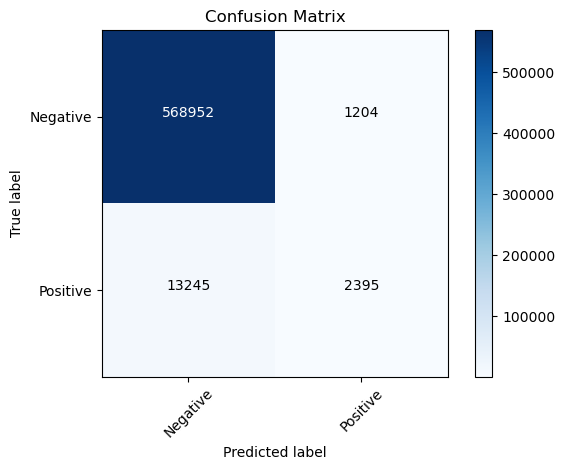

In [309]:
# Plot confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels
classes = ['Negative', 'Positive']  # Assuming class names
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add text annotations
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [154]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 4.5 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [155]:
from xgboost import XGBClassifier

In [239]:
xgb_classifier = XGBClassifier(random_state=42)

In [240]:
xgb_classifier.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [241]:
y_pred = xgb_classifier.predict(X)

In [242]:
y_pred_prob = xgb_classifier.predict_proba(X)

In [243]:
def thresh(array, threshold):
    mod_array = array[:,1]
    mod_array[mod_array >= threshold] = 1
    mod_array[mod_array < threshold] = 0
    
    return mod_array

In [244]:
y_pred = thresh(y_pred_prob, 0.9)

In [245]:
# Calculate precision
accuracy = accuracy_score(y, y_pred)

# Calculate precision
precision = precision_score(y, y_pred)

# Calculate recall
recall = recall_score(y, y_pred)

# Calculate F1 score
f1 = f1_score(y, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9748598488210913
Precision: 0.6124661246612466
Recall: 0.15895140664961638
F1 Score: 0.25239859891365046


In [246]:
conf_matrix = confusion_matrix(y, y_pred)

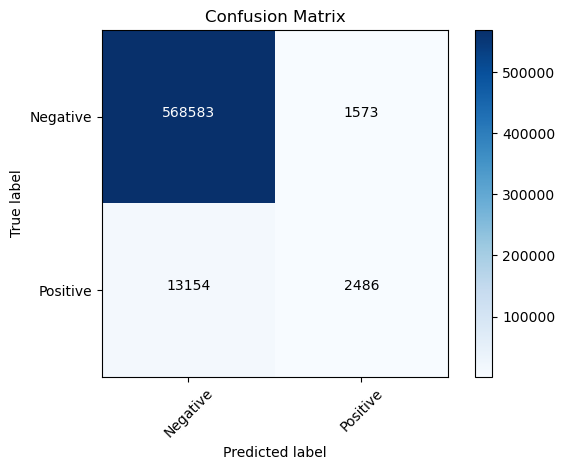

In [247]:
# Plot confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels
classes = ['Negative', 'Positive']  # Assuming class names
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add text annotations
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

# Under Sampling with more complex methods
We'll try combined over and undersampling now. We'll take our resampled data, and resample again first using TOMEK links.

In [624]:
len(y[y==1])/len(y[y==0])

0.02743108903528157

In [474]:
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours, InstanceHardnessThreshold

In [635]:
tl = InstanceHardnessThreshold(sampling_strategy=0.028)

In [636]:
X_undersampled, y_undersampled = tl.fit_resample(X, y)

In [637]:
rf_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=5, 
                                  min_samples_split=150, random_state=42, 
                                  n_jobs=-1) 
rf_model.fit(X_undersampled, y_undersampled)

RandomForestClassifier(min_samples_leaf=5, min_samples_split=150, n_jobs=-1,
                       random_state=42)

In [638]:
y_pred = rf_model.predict(X)

In [651]:
y_pred_prob = rf_model.predict_proba(X)

In [652]:
def thresh(array, threshold):
    mod_array = np.copy(array[:,1])
    mod_array[mod_array >= threshold] = 1
    mod_array[mod_array < threshold] = 0
    
    return mod_array

In [653]:
y_pred = thresh(y_pred_prob, 0.4)

In [654]:
# Calculate precision
accuracy = accuracy_score(y, y_pred)

# Calculate precision
precision = precision_score(y, y_pred)

# Calculate recall
recall = recall_score(y, y_pred)

# Calculate F1 score
f1 = f1_score(y, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9706177577177038
Precision: 0.41911916032105373
Recall: 0.26042199488491047
F1 Score: 0.3212398454136762


In [655]:
conf_matrix = confusion_matrix(y, y_pred)

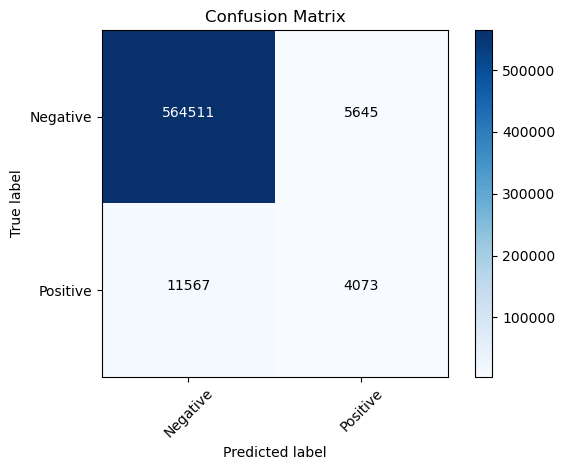

In [656]:
# Plot confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels
classes = ['Negative', 'Positive']  # Assuming class names
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add text annotations
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [ ]:
111919 and 8515

What happens with standard RF and just decreasing probability?

In [11]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

In [11]:
rf_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=5, 
                                  min_samples_split=150, random_state=42, 
                                  n_jobs=-1) #using all 4 cpus
rf_model.fit(X, y)

RandomForestClassifier(min_samples_leaf=5, min_samples_split=150, n_jobs=-1,
                       random_state=42)

In [21]:
y_pred_prob = rf_model.predict_proba(X)

In [22]:
def thresh(array, threshold):
    mod_array = np.copy(array[:,1])
    mod_array[mod_array >= threshold] = 1
    mod_array[mod_array < threshold] = 0
    
    return mod_array

In [23]:
y_pred = thresh(y_pred_prob, 0.05)

In [24]:
conf_matrix = confusion_matrix(y, y_pred)

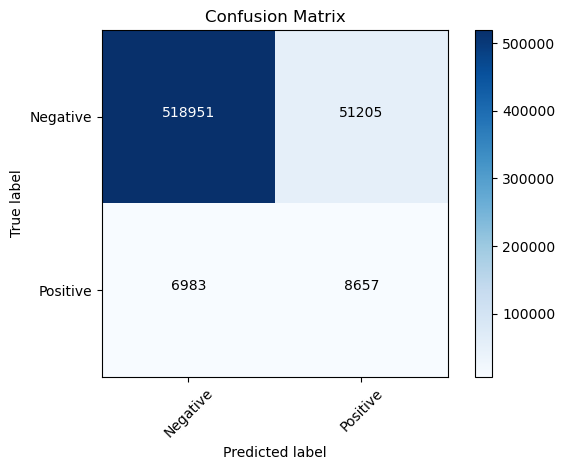

In [25]:
# Plot confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels
classes = ['Negative', 'Positive']  # Assuming class names
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add text annotations
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [657]:
xgb_classifier = XGBClassifier(random_state=42)

In [658]:
xgb_classifier.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [679]:
y_pred_prob = xgb_classifier.predict_proba(X)

In [680]:
def thresh(array, threshold):
    mod_array = np.copy(array[:,1])
    mod_array[mod_array >= threshold] = 1
    mod_array[mod_array < threshold] = 0
    
    return mod_array

In [681]:
y_pred = thresh(y_pred_prob, 0.5)

In [682]:
conf_matrix = confusion_matrix(y, y_pred)

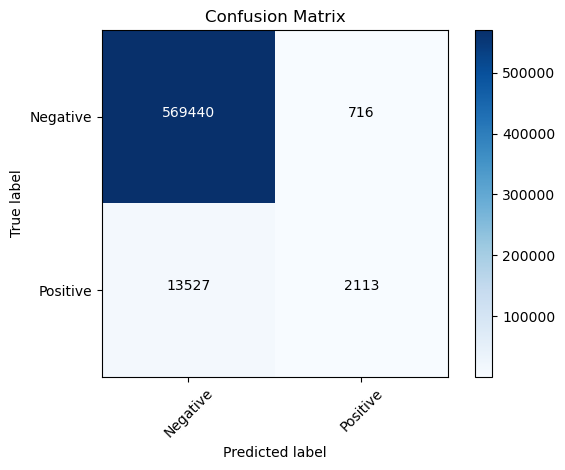

In [683]:
# Plot confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels
classes = ['Negative', 'Positive']  # Assuming class names
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add text annotations
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

XGBoost is a little bit better than Random Forest. We'll also try SVM. This takes many hours to train, so I'll dump the model into a pickle and then load the pickle for visualization.

In [10]:
from sklearn.svm import SVC

In [11]:
import joblib

In [12]:
svm_classifier = SVC(kernel='rbf', C=1.0, 
                     gamma='scale', probability=True,
                     random_state=42)

In [ ]:
svm_classifier.fit(X, y)

In [ ]:
joblib.dump(svm_classifier, 'svm_classifier_model.pkl')

Here's a pause for loading the model.

In [12]:
svm_classifier = joblib.load('svm_classifier_model.pkl')

In [20]:
y_pred_prob = svm_classifier.predict_proba(X)

In [26]:
store = np.copy(y_pred_prob)

In [22]:
def thresh(array, threshold):
    col = array[:,1]
    mod_array = np.copy(col)
    mod_array[mod_array >= threshold] = 1
    mod_array[mod_array < threshold] = 0
    
    return mod_array

In [33]:
y_pred = thresh(store2, 0.01)

TypeError: 'numpy.float64' object is not callable

In [34]:
conf_matrix = confusion_matrix(y, y_pred)

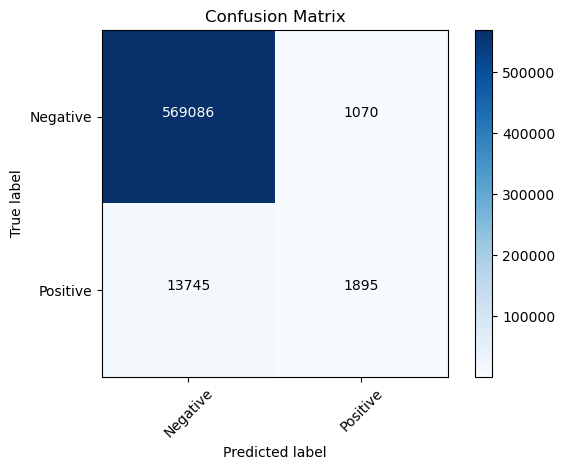

In [35]:
# Plot confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels
classes = ['Negative', 'Positive']  # Assuming class names
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add text annotations
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

For now SVM is not the direction to go in because it's not delineating well enough, especially given how long the training takes. For the sake of organization, I'm  going to split the following exploration into two parts:
1. Model Selection. We've tested RF above explicitly, without undersampling or oversampling and the same for SVM. We'll stick with ensemble methods here on out because their convergence timing to recall ratio is better than SVM on the dataset so far. We'll test these models: Random Forest (tested above), XGBoost, AdaBoost, Easy Ensemble, Roughly Balanced Bagging, Balanced Random Forest.
2. Data Downsampling. Then we'll test all those models again (with a hypothesis from model selection about what should work best) on downsampled data, following SMOTE, AdaSyn, and Marion's downsampling strategy.
3. Cross Validation. Once we have a model and a sampling strategy selected, we'll cross validate that model on F1 score, and create the confusion matrix for the paper.
4. Create Model Selection/Data Sampling/Cross Validation Notebook. Clean up this final notebook for the Jupyter Book 🎉

# Model Selection

We have the optimized Random Forest as the comparative standard in the notebook called "performance metrics." We'll compare the rest of the models with that.

## XGBoost

In [39]:
pip install xgboost

  Using cached xgboost-2.0.3-py3-none-manylinux2014_x86_64.whl.metadata (2.0 kB)
Using cached xgboost-2.0.3-py3-none-manylinux2014_x86_64.whl (297.1 MB)
Note: you may need to restart the kernel to use updated packages.


In [40]:
from xgboost import XGBClassifier

In [41]:
xgb_classifier = XGBClassifier(random_state=42)

In [53]:
xgb_classifier.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [54]:
y_pred_prob = xgb_classifier.predict_proba(X)

In [63]:
def thresh(array, threshold):
    col = array[:,1]
    mod_array = col.copy()
    mod_array[mod_array >= threshold] = 1
    mod_array[mod_array < threshold] = 0
    
    return mod_array

In [64]:
y_pred = thresh(y_pred_prob, 0.5)

In [65]:
conf_matrix = confusion_matrix(y, y_pred)

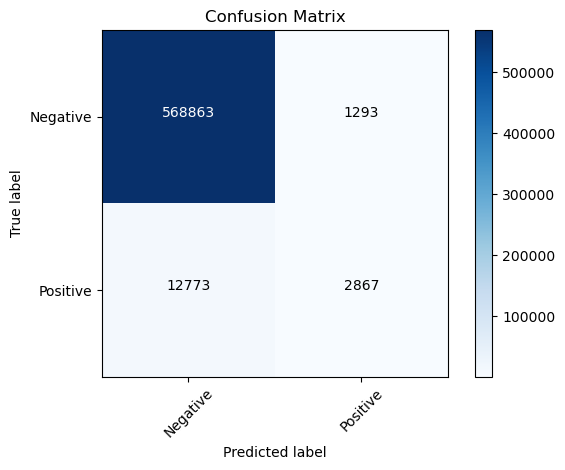

In [66]:
# Plot confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels
classes = ['Negative', 'Positive']  # Assuming class names
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add text annotations
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

### AdaBoost

In [67]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [68]:
adb_classifier = AdaBoostClassifier(n_estimators=1000, algorithm='SAMME', random_state=42)

In [69]:
adb_classifier.fit(X, y)

AdaBoostClassifier(algorithm='SAMME', n_estimators=1000, random_state=42)

In [70]:
y_pred_prob = adb_classifier.predict_proba(X)

In [79]:
def thresh(array, threshold):
    col = array[:,1].copy()
    mod_array = col.copy()
    mod_array[mod_array >= threshold] = 1
    mod_array[mod_array < threshold] = 0
    
    return mod_array

In [80]:
y_pred = thresh(y_pred_prob, 0.5)

In [81]:
conf_matrix = confusion_matrix(y, y_pred)

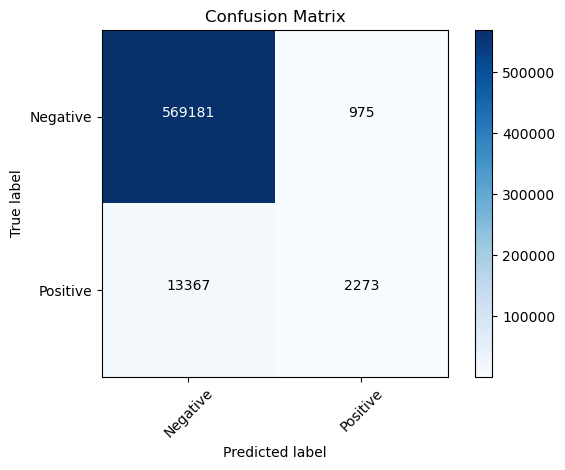

In [82]:
# Plot confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels
classes = ['Negative', 'Positive']  # Assuming class names
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add text annotations
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

### Easy Ensemble Classifier

In [83]:
! pip install imbalanced-learn

  Using cached imbalanced_learn-0.12.2-py3-none-any.whl.metadata (8.2 kB)
Using cached imbalanced_learn-0.12.2-py3-none-any.whl (257 kB)


In [84]:
from imblearn.ensemble import EasyEnsembleClassifier

In [85]:
ee_classifier = EasyEnsembleClassifier(random_state=42)

In [86]:
ee_classifier.fit(X, y)

EasyEnsembleClassifier(random_state=42)

In [87]:
y_pred_prob = ee_classifier.predict_proba(X)

In [104]:
def thresh(array, threshold):
    col = array[:,1].copy()
    mod_array = col.copy()
    mod_array[mod_array >= threshold] = 1
    mod_array[mod_array < threshold] = 0
    
    return mod_array

In [105]:
y_pred = thresh(y_pred_prob, 0.7)

In [106]:
conf_matrix = confusion_matrix(y, y_pred)

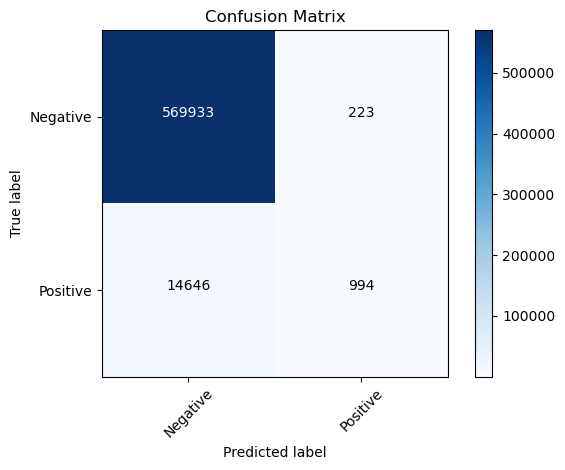

In [107]:
# Plot confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels
classes = ['Negative', 'Positive']  # Assuming class names
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add text annotations
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

### Balanced Random Forest (though in our case slightly balanced?)

This should undergo some cross validation on the sampling strategy.

In [13]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [14]:
from sklearn.model_selection import train_test_split

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [47]:
len(y_train[y_train == 1])/len(y_train)

0.026620967497192803

In [48]:
len(y_test[y_test == 1])/len(y_test)

0.027398429498122226

In [49]:
len(y[y==1])/len(y)

0.02669871422816134

In [50]:
# brf_classifier = BalancedRandomForestClassifier(sampling_strategy=0.03, replacement=True, 
#                                                 random_state=42, bootstrap=False)
brf_classifier = BalancedRandomForestClassifier(sampling_strategy=0.028, replacement=True, 
                                                random_state=42, bootstrap=False)

In [51]:
brf_classifier.fit(X_train, y_train)

BalancedRandomForestClassifier(bootstrap=False, random_state=42,
                               replacement=True, sampling_strategy=0.028)

In [63]:
y_pred_prob = brf_classifier.predict_proba(X_test)

In [72]:
def thresh(array, threshold):
    col = array[:,1].copy()
    mod_array = col.copy()
    mod_array[mod_array >= threshold] = 1
    mod_array[mod_array < threshold] = 0
    
    return mod_array

In [73]:
y_pred = thresh(y_pred_prob, 0.9)

In [74]:
conf_matrix = confusion_matrix(y_test, y_pred)

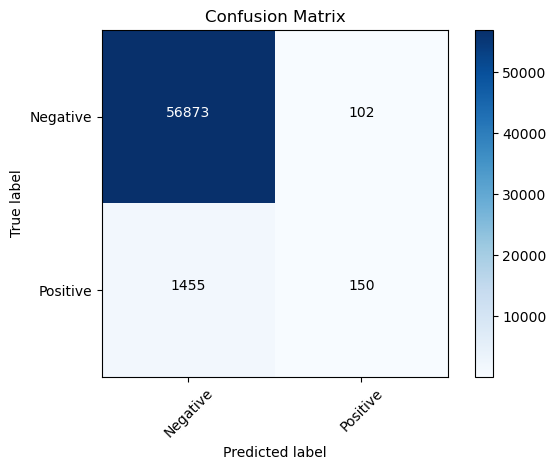

In [75]:
# Plot confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels
classes = ['Negative', 'Positive']  # Assuming class names
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add text annotations
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

### Exactly Balanced Bagging (though in our case slightly balanced?)

In [323]:
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.under_sampling import RandomUnderSampler

In [344]:
ebb_classifier = BalancedBaggingClassifier(sampler=RandomUnderSampler(sampling_strategy=0.28))

In [345]:
ebb_classifier.fit(X, y)

BalancedBaggingClassifier(sampler=RandomUnderSampler(sampling_strategy=0.28))

In [346]:
y_pred_prob = ebb_classifier.predict_proba(X)

In [347]:
def thresh(array, threshold):
    col = array[:,1].copy()
    mod_array = col.copy()
    mod_array[mod_array >= threshold] = 1
    mod_array[mod_array < threshold] = 0
    
    return mod_array

In [348]:
y_pred = thresh(y_pred_prob, 0.9)

In [349]:
conf_matrix = confusion_matrix(y, y_pred)

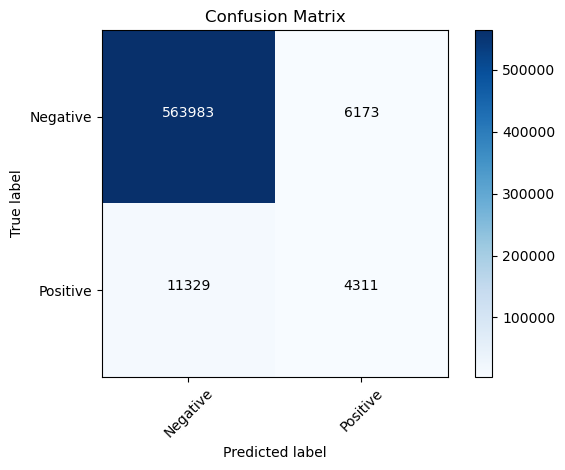

In [350]:
# Plot confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels
classes = ['Negative', 'Positive']  # Assuming class names
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add text annotations
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

### Revisiting Slightly Balanced Random Forest

#### Collapsible code mod to imbalanced learn

In [355]:
"""Forest classifiers trained on balanced boostrasp samples."""

# Authors: Guillaume Lemaitre <g.lemaitre58@gmail.com>
# License: MIT

import numbers
from copy import deepcopy
from warnings import warn

import numpy as np
import sklearn
from numpy import float32 as DTYPE
from numpy import float64 as DOUBLE
from scipy.sparse import issparse
from sklearn.base import clone, is_classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble._base import _set_random_states
from sklearn.ensemble._forest import (
    _generate_unsampled_indices,
    _get_n_samples_bootstrap,
    _parallel_build_trees,
)
from sklearn.exceptions import DataConversionWarning
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import _safe_indexing, check_random_state
from sklearn.utils.fixes import parse_version
from sklearn.utils.multiclass import type_of_target
from sklearn.utils.validation import _check_sample_weight

try:
    # scikit-learn >= 1.2
    from sklearn.utils.parallel import Parallel, delayed
except (ImportError, ModuleNotFoundError):
    from joblib import Parallel
    from sklearn.utils.fixes import delayed

from imblearn.base import _ParamsValidationMixin
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours
from imblearn.utils import Substitution
from imblearn.utils._docstring import _n_jobs_docstring, _random_state_docstring
from imblearn.utils._param_validation import Hidden, Interval, StrOptions
from imblearn.utils._validation import check_sampling_strategy
from imblearn.utils.fixes import _fit_context
# from imblearn import _random_forest_classifier_parameter_constraints

In [357]:
sklearn.__version__

'1.4.1.post1'

In [365]:
MAX_INT = np.iinfo(np.int32).max
sklearn_version = parse_version(sklearn.__version__)


def _local_parallel_build_trees(
    sampler,
    tree,
    bootstrap,
    X,
    y,
    sample_weight,
    tree_idx,
    n_trees,
    verbose=0,
    class_weight=None,
    n_samples_bootstrap=None,
    forest=None,
    missing_values_in_feature_mask=None,
):
    # resample before to fit the tree
    X_resampled, y_resampled = sampler.fit_resample(X, y)
    if sample_weight is not None:
        sample_weight = _safe_indexing(sample_weight, sampler.sample_indices_)
    if _get_n_samples_bootstrap is not None:
        n_samples_bootstrap = min(n_samples_bootstrap, X_resampled.shape[0])

    params_parallel_build_trees = {
        "tree": tree,
        "X": X_resampled,
        "y": y_resampled,
        "sample_weight": sample_weight,
        "tree_idx": tree_idx,
        "n_trees": n_trees,
        "verbose": verbose,
        "class_weight": class_weight,
        "n_samples_bootstrap": n_samples_bootstrap,
    }

    if parse_version(sklearn_version.base_version) >= parse_version("1.4"):
        # TODO: remove when the minimum supported version of scikit-learn will be 1.4
        # support for missing values
        params_parallel_build_trees[
            "missing_values_in_feature_mask"
        ] = missing_values_in_feature_mask

    # TODO: remove when the minimum supported version of scikit-learn will be 1.1
    # change of signature in scikit-learn 1.1
    if parse_version(sklearn_version.base_version) >= parse_version("1.1"):
        params_parallel_build_trees["bootstrap"] = bootstrap
    else:
        params_parallel_build_trees["forest"] = forest

    tree = _parallel_build_trees(**params_parallel_build_trees)

    return sampler, tree


@Substitution(
    n_jobs=_n_jobs_docstring,
    random_state=_random_state_docstring,
)
class BarelyBalancedRandomForestClassifier(_ParamsValidationMixin, RandomForestClassifier):
    """A balanced random forest classifier.

    A balanced random forest differs from a classical random forest by the
    fact that it will draw a bootstrap sample from the minority class and
    sample with replacement the same number of samples from the majority
    class.

    Read more in the :ref:`User Guide <forest>`.

    .. versionadded:: 0.4

    Parameters
    ----------
    n_estimators : int, default=100
        The number of trees in the forest.

    criterion : {{"gini", "entropy"}}, default="gini"
        The function to measure the quality of a split. Supported criteria are
        "gini" for the Gini impurity and "entropy" for the information gain.
        Note: this parameter is tree-specific.

    max_depth : int, default=None
        The maximum depth of the tree. If None, then nodes are expanded until
        all leaves are pure or until all leaves contain less than
        min_samples_split samples.

    min_samples_split : int or float, default=2
        The minimum number of samples required to split an internal node:

        - If int, then consider `min_samples_split` as the minimum number.
        - If float, then `min_samples_split` is a percentage and
          `ceil(min_samples_split * n_samples)` are the minimum
          number of samples for each split.

    min_samples_leaf : int or float, default=1
        The minimum number of samples required to be at a leaf node:

        - If int, then consider ``min_samples_leaf`` as the minimum number.
        - If float, then ``min_samples_leaf`` is a fraction and
          `ceil(min_samples_leaf * n_samples)` are the minimum
          number of samples for each node.

    min_weight_fraction_leaf : float, default=0.0
        The minimum weighted fraction of the sum total of weights (of all
        the input samples) required to be at a leaf node. Samples have
        equal weight when sample_weight is not provided.

    max_features : {{"auto", "sqrt", "log2"}}, int, float, or None, \
            default="sqrt"
        The number of features to consider when looking for the best split:

        - If int, then consider `max_features` features at each split.
        - If float, then `max_features` is a percentage and
          `int(max_features * n_features)` features are considered at each
          split.
        - If "auto", then `max_features=sqrt(n_features)`.
        - If "sqrt", then `max_features=sqrt(n_features)` (same as "auto").
        - If "log2", then `max_features=log2(n_features)`.
        - If None, then `max_features=n_features`.

        Note: the search for a split does not stop until at least one
        valid partition of the node samples is found, even if it requires to
        effectively inspect more than ``max_features`` features.

    max_leaf_nodes : int, default=None
        Grow trees with ``max_leaf_nodes`` in best-first fashion.
        Best nodes are defined as relative reduction in impurity.
        If None then unlimited number of leaf nodes.

    min_impurity_decrease : float, default=0.0
        A node will be split if this split induces a decrease of the impurity
        greater than or equal to this value.
        The weighted impurity decrease equation is the following::

            N_t / N * (impurity - N_t_R / N_t * right_impurity
                                - N_t_L / N_t * left_impurity)

        where ``N`` is the total number of samples, ``N_t`` is the number of
        samples at the current node, ``N_t_L`` is the number of samples in the
        left child, and ``N_t_R`` is the number of samples in the right child.
        ``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,
        if ``sample_weight`` is passed.

    bootstrap : bool, default=True
        Whether bootstrap samples are used when building trees.

        .. versionchanged:: 0.13
           The default of `bootstrap` will change from `True` to `False` in
           version 0.13. Bootstrapping is already taken care by the internal
           sampler using `replacement=True`. This implementation follows the
           algorithm proposed in [1]_.

    oob_score : bool, default=False
        Whether to use out-of-bag samples to estimate
        the generalization accuracy.

    sampling_strategy : float, str, dict, callable, default="auto"
        Sampling information to sample the data set.

        - When ``float``, it corresponds to the desired ratio of the number of
          samples in the minority class over the number of samples in the
          majority class after resampling. Therefore, the ratio is expressed as
          :math:`\\alpha_{{us}} = N_{{m}} / N_{{rM}}` where :math:`N_{{m}}` is the
          number of samples in the minority class and
          :math:`N_{{rM}}` is the number of samples in the majority class
          after resampling.

          .. warning::
             ``float`` is only available for **binary** classification. An
             error is raised for multi-class classification.

        - When ``str``, specify the class targeted by the resampling. The
          number of samples in the different classes will be equalized.
          Possible choices are:

            ``'majority'``: resample only the majority class;

            ``'not minority'``: resample all classes but the minority class;

            ``'not majority'``: resample all classes but the majority class;

            ``'all'``: resample all classes;

            ``'auto'``: equivalent to ``'not minority'``.

        - When ``dict``, the keys correspond to the targeted classes. The
          values correspond to the desired number of samples for each targeted
          class.

        - When callable, function taking ``y`` and returns a ``dict``. The keys
          correspond to the targeted classes. The values correspond to the
          desired number of samples for each class.

        .. versionchanged:: 0.11
           The default of `sampling_strategy` will change from `"auto"` to
           `"all"` in version 0.13. This forces to use a bootstrap of the
           minority class as proposed in [1]_.

    replacement : bool, default=False
        Whether or not to sample randomly with replacement or not.

        .. versionchanged:: 0.11
           The default of `replacement` will change from `False` to `True` in
           version 0.13. This forces to use a bootstrap of the
           minority class and draw with replacement as proposed in [1]_.

    {n_jobs}

    {random_state}

    verbose : int, default=0
        Controls the verbosity of the tree building process.

    warm_start : bool, default=False
        When set to ``True``, reuse the solution of the previous call to fit
        and add more estimators to the ensemble, otherwise, just fit a whole
        new forest.

    class_weight : dict, list of dicts, {{"balanced", "balanced_subsample"}}, \
            default=None
        Weights associated with classes in the form dictionary with the key
        being the class_label and the value the weight.
        If not given, all classes are supposed to have weight one. For
        multi-output problems, a list of dicts can be provided in the same
        order as the columns of y.
        Note that for multioutput (including multilabel) weights should be
        defined for each class of every column in its own dict. For example,
        for four-class multilabel classification weights should be
        [{{0: 1, 1: 1}}, {{0: 1, 1: 5}}, {{0: 1, 1: 1}}, {{0: 1, 1: 1}}]
        instead of [{{1:1}}, {{2:5}}, {{3:1}}, {{4:1}}].
        The "balanced" mode uses the values of y to automatically adjust
        weights inversely proportional to class frequencies in the input data
        as ``n_samples / (n_classes * np.bincount(y))``
        The "balanced_subsample" mode is the same as "balanced" except that
        weights are computed based on the bootstrap sample for every tree
        grown.
        For multi-output, the weights of each column of y will be multiplied.
        Note that these weights will be multiplied with sample_weight (passed
        through the fit method) if sample_weight is specified.

    ccp_alpha : non-negative float, default=0.0
        Complexity parameter used for Minimal Cost-Complexity Pruning. The
        subtree with the largest cost complexity that is smaller than
        ``ccp_alpha`` will be chosen. By default, no pruning is performed.

        .. versionadded:: 0.6
           Added in `scikit-learn` in 0.22

    max_samples : int or float, default=None
        If bootstrap is True, the number of samples to draw from X
        to train each base estimator.
            - If None (default), then draw `X.shape[0]` samples.
            - If int, then draw `max_samples` samples.
            - If float, then draw `max_samples * X.shape[0]` samples. Thus,
              `max_samples` should be in the interval `(0, 1)`.
        Be aware that the final number samples used will be the minimum between
        the number of samples given in `max_samples` and the number of samples
        obtained after resampling.

        .. versionadded:: 0.6
           Added in `scikit-learn` in 0.22

    monotonic_cst : array-like of int of shape (n_features), default=None
        Indicates the monotonicity constraint to enforce on each feature.
          - 1: monotonic increase
          - 0: no constraint
          - -1: monotonic decrease

        If monotonic_cst is None, no constraints are applied.

        Monotonicity constraints are not supported for:
          - multiclass classifications (i.e. when `n_classes > 2`),
          - multioutput classifications (i.e. when `n_outputs_ > 1`),
          - classifications trained on data with missing values.

        The constraints hold over the probability of the positive class.

        .. versionadded:: 0.12
           Only supported when scikit-learn >= 1.4 is installed. Otherwise, a
           `ValueError` is raised.

    Attributes
    ----------
    estimator_ : :class:`~sklearn.tree.DecisionTreeClassifier` instance
        The child estimator template used to create the collection of fitted
        sub-estimators.

        .. versionadded:: 0.10

    estimators_ : list of :class:`~sklearn.tree.DecisionTreeClassifier`
        The collection of fitted sub-estimators.

    base_sampler_ : :class:`~imblearn.under_sampling.RandomUnderSampler`
        The base sampler used to construct the subsequent list of samplers.

    samplers_ : list of :class:`~imblearn.under_sampling.RandomUnderSampler`
        The collection of fitted samplers.

    pipelines_ : list of Pipeline.
        The collection of fitted pipelines (samplers + trees).

    classes_ : ndarray of shape (n_classes,) or a list of such arrays
        The classes labels (single output problem), or a list of arrays of
        class labels (multi-output problem).

    n_classes_ : int or list
        The number of classes (single output problem), or a list containing the
        number of classes for each output (multi-output problem).

    n_features_ : int
        The number of features when `fit` is performed.

        .. deprecated:: 1.0
           `n_features_` is deprecated in `scikit-learn` 1.0 and will be removed
           in version 1.2. When the minimum version of `scikit-learn` supported
           by `imbalanced-learn` will reach 1.2, this attribute will be removed.

    n_features_in_ : int
        Number of features in the input dataset.

        .. versionadded:: 0.9

    feature_names_in_ : ndarray of shape (`n_features_in_`,)
        Names of features seen during `fit`. Defined only when `X` has feature
        names that are all strings.

        .. versionadded:: 0.9

    n_outputs_ : int
        The number of outputs when ``fit`` is performed.

    feature_importances_ : ndarray of shape (n_features,)
        The feature importances (the higher, the more important the feature).

    oob_score_ : float
        Score of the training dataset obtained using an out-of-bag estimate.

    oob_decision_function_ : ndarray of shape (n_samples, n_classes)
        Decision function computed with out-of-bag estimate on the training
        set. If n_estimators is small it might be possible that a data point
        was never left out during the bootstrap. In this case,
        `oob_decision_function_` might contain NaN.

    See Also
    --------
    BalancedBaggingClassifier : Bagging classifier for which each base
        estimator is trained on a balanced bootstrap.

    EasyEnsembleClassifier : Ensemble of AdaBoost classifier trained on
        balanced bootstraps.

    RUSBoostClassifier : AdaBoost classifier were each bootstrap is balanced
        using random-under sampling at each round of boosting.

    References
    ----------
    .. [1] Chen, Chao, Andy Liaw, and Leo Breiman. "Using random forest to
       learn imbalanced data." University of California, Berkeley 110 (2004):
       1-12.

    Examples
    --------
    >>> from imblearn.ensemble import BalancedRandomForestClassifier
    >>> from sklearn.datasets import make_classification
    >>>
    >>> X, y = make_classification(n_samples=1000, n_classes=3,
    ...                            n_informative=4, weights=[0.2, 0.3, 0.5],
    ...                            random_state=0)
    >>> clf = BalancedRandomForestClassifier(
    ...     sampling_strategy="all", replacement=True, max_depth=2, random_state=0,
    ...     bootstrap=False)
    >>> clf.fit(X, y)
    BalancedRandomForestClassifier(...)
    >>> print(clf.feature_importances_)
    [...]
    >>> print(clf.predict([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    ...                     0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]))
    [1]
    """

    # make a deepcopy to not modify the original dictionary
    if sklearn_version >= parse_version("1.4"):
        _parameter_constraints = deepcopy(RandomForestClassifier._parameter_constraints)
    # else:
    #     _parameter_constraints = deepcopy(
    #         _random_forest_classifier_parameter_constraints
    #     )

    _parameter_constraints.update(
        {
            "bootstrap": ["boolean", Hidden(StrOptions({"warn"}))],
            "sampling_strategy": [
                Interval(numbers.Real, 0, 1, closed="right"),
                StrOptions({"auto", "majority", "not minority", "not majority", "all"}),
                dict,
                callable,
                Hidden(StrOptions({"warn"})),
            ],
            "replacement": ["boolean", Hidden(StrOptions({"warn"}))],
        }
    )

    def __init__(
        self,
        n_estimators=100,
        *,
        criterion="gini",
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        max_features="sqrt",
        max_leaf_nodes=None,
        min_impurity_decrease=0.0,
        bootstrap="warn",
        oob_score=False,
        sampling_strategy="warn",
        replacement="warn",
        n_jobs=None,
        random_state=None,
        verbose=0,
        warm_start=False,
        class_weight=None,
        ccp_alpha=0.0,
        max_samples=None,
        monotonic_cst=None,
    ):
        params_random_forest = {
            "criterion": criterion,
            "max_depth": max_depth,
            "n_estimators": n_estimators,
            "bootstrap": bootstrap,
            "oob_score": oob_score,
            "n_jobs": n_jobs,
            "random_state": random_state,
            "verbose": verbose,
            "warm_start": warm_start,
            "class_weight": class_weight,
            "min_samples_split": min_samples_split,
            "min_samples_leaf": min_samples_leaf,
            "min_weight_fraction_leaf": min_weight_fraction_leaf,
            "max_features": max_features,
            "max_leaf_nodes": max_leaf_nodes,
            "min_impurity_decrease": min_impurity_decrease,
            "ccp_alpha": ccp_alpha,
            "max_samples": max_samples,
        }
        # TODO: remove when the minimum supported version of scikit-learn will be 1.4
        if parse_version(sklearn_version.base_version) >= parse_version("1.4"):
            # use scikit-learn support for monotonic constraints
            params_random_forest["monotonic_cst"] = monotonic_cst
        else:
            if monotonic_cst is not None:
                raise ValueError(
                    "Monotonic constraints are not supported for scikit-learn "
                    "version < 1.4."
                )
            # create an attribute for compatibility with other scikit-learn tools such
            # as HTML representation.
            self.monotonic_cst = monotonic_cst
        super().__init__(**params_random_forest)

        self.sampling_strategy = sampling_strategy
        self.replacement = replacement

    def _validate_estimator(self, default=DecisionTreeClassifier()):
        """Check the estimator and the n_estimator attribute, set the
        `estimator_` attribute."""
        if hasattr(self, "estimator"):
            base_estimator = self.estimator
        else:
            base_estimator = self.base_estimator

        if base_estimator is not None:
            self.estimator_ = clone(base_estimator)
        else:
            self.estimator_ = clone(default)

        # self.base_sampler_ = RandomUnderSampler(
        #     sampling_strategy=self._sampling_strategy,
        #     replacement=self._replacement,
        # )

        self.base_sampler_ = EditedNearestNeighbours(
            sampling_strategy=self._sampling_strategy,
            n_neighbors=5,
        )

    def _make_sampler_estimator(self, random_state=None):
        """Make and configure a copy of the `base_estimator_` attribute.
        Warning: This method should be used to properly instantiate new
        sub-estimators.
        """
        estimator = clone(self.estimator_)
        estimator.set_params(**{p: getattr(self, p) for p in self.estimator_params})
        sampler = clone(self.base_sampler_)

        if random_state is not None:
            _set_random_states(estimator, random_state)
            _set_random_states(sampler, random_state)

        return estimator, sampler

    @_fit_context(prefer_skip_nested_validation=True)
    def fit(self, X, y, sample_weight=None):
        """Build a forest of trees from the training set (X, y).

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The training input samples. Internally, its dtype will be converted
            to ``dtype=np.float32``. If a sparse matrix is provided, it will be
            converted into a sparse ``csc_matrix``.

        y : array-like of shape (n_samples,) or (n_samples, n_outputs)
            The target values (class labels in classification, real numbers in
            regression).

        sample_weight : array-like of shape (n_samples,)
            Sample weights. If None, then samples are equally weighted. Splits
            that would create child nodes with net zero or negative weight are
            ignored while searching for a split in each node. In the case of
            classification, splits are also ignored if they would result in any
            single class carrying a negative weight in either child node.

        Returns
        -------
        self : object
            The fitted instance.
        """
        self._validate_params()
        # TODO: remove in 0.13
        if self.sampling_strategy == "warn":
            warn(
                "The default of `sampling_strategy` will change from `'auto'` to "
                "`'all'` in version 0.13. This change will follow the implementation "
                "proposed in the original paper. Set to `'all'` to silence this "
                "warning and adopt the future behaviour.",
                FutureWarning,
            )
            self._sampling_strategy = "auto"
        else:
            self._sampling_strategy = self.sampling_strategy

        if self.replacement == "warn":
            warn(
                "The default of `replacement` will change from `False` to "
                "`True` in version 0.13. This change will follow the implementation "
                "proposed in the original paper. Set to `True` to silence this "
                "warning and adopt the future behaviour.",
                FutureWarning,
            )
            self._replacement = False
        else:
            self._replacement = self.replacement

        if self.bootstrap == "warn":
            warn(
                "The default of `bootstrap` will change from `True` to "
                "`False` in version 0.13. This change will follow the implementation "
                "proposed in the original paper. Set to `False` to silence this "
                "warning and adopt the future behaviour.",
                FutureWarning,
            )
            self._bootstrap = True
        else:
            self._bootstrap = self.bootstrap

        # Validate or convert input data
        if issparse(y):
            raise ValueError("sparse multilabel-indicator for y is not supported.")

        # TODO: remove when the minimum supported version of scipy will be 1.4
        # Support for missing values
        if parse_version(sklearn_version.base_version) >= parse_version("1.4"):
            force_all_finite = False
        else:
            force_all_finite = True

        X, y = self._validate_data(
            X,
            y,
            multi_output=True,
            accept_sparse="csc",
            dtype=DTYPE,
            force_all_finite=force_all_finite,
        )

        # TODO: remove when the minimum supported version of scikit-learn will be 1.4
        if parse_version(sklearn_version.base_version) >= parse_version("1.4"):
            # _compute_missing_values_in_feature_mask checks if X has missing values and
            # will raise an error if the underlying tree base estimator can't handle
            # missing values. Only the criterion is required to determine if the tree
            # supports missing values.
            estimator = type(self.estimator)(criterion=self.criterion)
            missing_values_in_feature_mask = (
                estimator._compute_missing_values_in_feature_mask(
                    X, estimator_name=self.__class__.__name__
                )
            )
        else:
            missing_values_in_feature_mask = None

        if sample_weight is not None:
            sample_weight = _check_sample_weight(sample_weight, X)

        self._n_features = X.shape[1]

        if issparse(X):
            # Pre-sort indices to avoid that each individual tree of the
            # ensemble sorts the indices.
            X.sort_indices()

        y = np.atleast_1d(y)
        if y.ndim == 2 and y.shape[1] == 1:
            warn(
                "A column-vector y was passed when a 1d array was"
                " expected. Please change the shape of y to "
                "(n_samples,), for example using ravel().",
                DataConversionWarning,
                stacklevel=2,
            )

        if y.ndim == 1:
            # reshape is necessary to preserve the data contiguity against vs
            # [:, np.newaxis] that does not.
            y = np.reshape(y, (-1, 1))

        self.n_outputs_ = y.shape[1]

        y_encoded, expanded_class_weight = self._validate_y_class_weight(y)

        if getattr(y, "dtype", None) != DOUBLE or not y.flags.contiguous:
            y_encoded = np.ascontiguousarray(y_encoded, dtype=DOUBLE)

        if isinstance(self._sampling_strategy, dict):
            self._sampling_strategy = {
                np.where(self.classes_[0] == key)[0][0]: value
                for key, value in check_sampling_strategy(
                    self.sampling_strategy,
                    y,
                    "under-sampling",
                ).items()
            }
        else:
            self._sampling_strategy = self._sampling_strategy

        if expanded_class_weight is not None:
            if sample_weight is not None:
                sample_weight = sample_weight * expanded_class_weight
            else:
                sample_weight = expanded_class_weight

        # Get bootstrap sample size
        n_samples_bootstrap = _get_n_samples_bootstrap(
            n_samples=X.shape[0], max_samples=self.max_samples
        )

        # Check parameters
        self._validate_estimator()

        if not self._bootstrap and self.oob_score:
            raise ValueError("Out of bag estimation only available if bootstrap=True")

        random_state = check_random_state(self.random_state)

        if not self.warm_start or not hasattr(self, "estimators_"):
            # Free allocated memory, if any
            self.estimators_ = []
            self.samplers_ = []
            self.pipelines_ = []

        n_more_estimators = self.n_estimators - len(self.estimators_)

        if n_more_estimators < 0:
            raise ValueError(
                "n_estimators=%d must be larger or equal to "
                "len(estimators_)=%d when warm_start==True"
                % (self.n_estimators, len(self.estimators_))
            )

        elif n_more_estimators == 0:
            warn(
                "Warm-start fitting without increasing n_estimators does not "
                "fit new trees."
            )
        else:
            if self.warm_start and len(self.estimators_) > 0:
                # We draw from the random state to get the random state we
                # would have got if we hadn't used a warm_start.
                random_state.randint(MAX_INT, size=len(self.estimators_))

            trees = []
            samplers = []
            for _ in range(n_more_estimators):
                tree, sampler = self._make_sampler_estimator(random_state=random_state)
                trees.append(tree)
                samplers.append(sampler)

            # Parallel loop: we prefer the threading backend as the Cython code
            # for fitting the trees is internally releasing the Python GIL
            # making threading more efficient than multiprocessing in
            # that case. However, we respect any parallel_backend contexts set
            # at a higher level, since correctness does not rely on using
            # threads.
            samplers_trees = Parallel(
                n_jobs=self.n_jobs,
                verbose=self.verbose,
                prefer="threads",
            )(
                delayed(_local_parallel_build_trees)(
                    s,
                    t,
                    self._bootstrap,
                    X,
                    y_encoded,
                    sample_weight,
                    i,
                    len(trees),
                    verbose=self.verbose,
                    class_weight=self.class_weight,
                    n_samples_bootstrap=n_samples_bootstrap,
                    forest=self,
                    missing_values_in_feature_mask=missing_values_in_feature_mask,
                )
                for i, (s, t) in enumerate(zip(samplers, trees))
            )
            samplers, trees = zip(*samplers_trees)

            # Collect newly grown trees
            self.estimators_.extend(trees)
            self.samplers_.extend(samplers)

            # Create pipeline with the fitted samplers and trees
            self.pipelines_.extend(
                [
                    make_pipeline(deepcopy(s), deepcopy(t))
                    for s, t in zip(samplers, trees)
                ]
            )

        if self.oob_score:
            y_type = type_of_target(y)
            if y_type in ("multiclass-multioutput", "unknown"):
                # FIXME: we could consider to support multiclass-multioutput if
                # we introduce or reuse a constructor parameter (e.g.
                # oob_score) allowing our user to pass a callable defining the
                # scoring strategy on OOB sample.
                raise ValueError(
                    "The type of target cannot be used to compute OOB "
                    f"estimates. Got {y_type} while only the following are "
                    "supported: continuous, continuous-multioutput, binary, "
                    "multiclass, multilabel-indicator."
                )
            self._set_oob_score_and_attributes(X, y_encoded)

        # Decapsulate classes_ attributes
        if hasattr(self, "classes_") and self.n_outputs_ == 1:
            self.n_classes_ = self.n_classes_[0]
            self.classes_ = self.classes_[0]

        return self

    def _set_oob_score_and_attributes(self, X, y):
        """Compute and set the OOB score and attributes.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The data matrix.
        y : ndarray of shape (n_samples, n_outputs)
            The target matrix.
        """
        self.oob_decision_function_ = self._compute_oob_predictions(X, y)
        if self.oob_decision_function_.shape[-1] == 1:
            # drop the n_outputs axis if there is a single output
            self.oob_decision_function_ = self.oob_decision_function_.squeeze(axis=-1)
        from sklearn.metrics import accuracy_score

        self.oob_score_ = accuracy_score(
            y, np.argmax(self.oob_decision_function_, axis=1)
        )

    def _compute_oob_predictions(self, X, y):
        """Compute and set the OOB score.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The data matrix.
        y : ndarray of shape (n_samples, n_outputs)
            The target matrix.

        Returns
        -------
        oob_pred : ndarray of shape (n_samples, n_classes, n_outputs) or \
                (n_samples, 1, n_outputs)
            The OOB predictions.
        """
        # Prediction requires X to be in CSR format
        if issparse(X):
            X = X.tocsr()

        n_samples = y.shape[0]
        n_outputs = self.n_outputs_

        if is_classifier(self) and hasattr(self, "n_classes_"):
            # n_classes_ is a ndarray at this stage
            # all the supported type of target will have the same number of
            # classes in all outputs
            oob_pred_shape = (n_samples, self.n_classes_[0], n_outputs)
        else:
            # for regression, n_classes_ does not exist and we create an empty
            # axis to be consistent with the classification case and make
            # the array operations compatible with the 2 settings
            oob_pred_shape = (n_samples, 1, n_outputs)

        oob_pred = np.zeros(shape=oob_pred_shape, dtype=np.float64)
        n_oob_pred = np.zeros((n_samples, n_outputs), dtype=np.int64)

        for sampler, estimator in zip(self.samplers_, self.estimators_):
            X_resample = X[sampler.sample_indices_]
            y_resample = y[sampler.sample_indices_]

            n_sample_subset = y_resample.shape[0]
            n_samples_bootstrap = _get_n_samples_bootstrap(
                n_sample_subset, self.max_samples
            )

            unsampled_indices = _generate_unsampled_indices(
                estimator.random_state, n_sample_subset, n_samples_bootstrap
            )

            y_pred = self._get_oob_predictions(
                estimator, X_resample[unsampled_indices, :]
            )

            indices = sampler.sample_indices_[unsampled_indices]
            oob_pred[indices, ...] += y_pred
            n_oob_pred[indices, :] += 1

        for k in range(n_outputs):
            if (n_oob_pred == 0).any():
                warn(
                    "Some inputs do not have OOB scores. This probably means "
                    "too few trees were used to compute any reliable OOB "
                    "estimates.",
                    UserWarning,
                )
                n_oob_pred[n_oob_pred == 0] = 1
            oob_pred[..., k] /= n_oob_pred[..., [k]]

        return oob_pred

    # TODO: remove when supporting scikit-learn>=1.2
    @property
    def n_features_(self):
        """Number of features when ``fit`` is performed."""
        warn(
            "`n_features_` was deprecated in scikit-learn 1.0. This attribute will "
            "not be accessible when the minimum supported version of scikit-learn "
            "is 1.2.",
            FutureWarning,
        )
        return self.n_features_in_

    def _more_tags(self):
        return {
            "multioutput": False,
            "multilabel": False,
        }

#### Back to model testing

In [370]:
bbrf_classifier = BarelyBalancedRandomForestClassifier(sampling_strategy='not minority', replacement=True, 
                                                       random_state=42, bootstrap=False)

In [371]:
bbrf_classifier.fit(X, y)

BarelyBalancedRandomForestClassifier(bootstrap=False, random_state=42,
                                     replacement=True,
                                     sampling_strategy='not minority')

In [373]:
y_pred_prob = bbrf_classifier.predict_proba(X)

In [374]:
def thresh(array, threshold):
    col = array[:,1].copy()
    mod_array = col.copy()
    mod_array[mod_array >= threshold] = 1
    mod_array[mod_array < threshold] = 0
    
    return mod_array

In [375]:
y_pred = thresh(y_pred_prob, 0.9)

In [376]:
conf_matrix = confusion_matrix(y, y_pred)

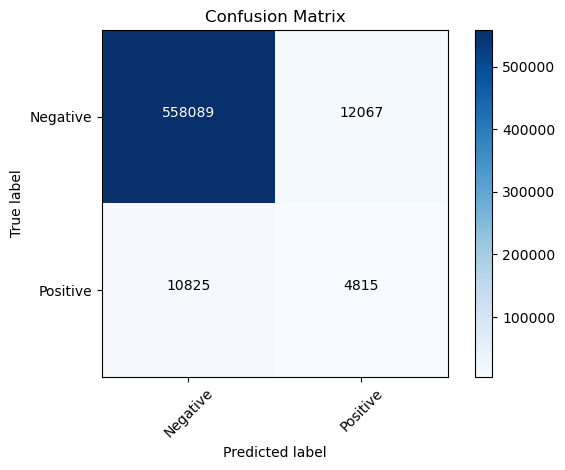

In [377]:
# Plot confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels
classes = ['Negative', 'Positive']  # Assuming class names
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add text annotations
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

There appears to be something unique that happens when we're resampling at the ratio right near our actual class balance. Weird!

### Visualizing the Best Method Thus Far (Slightly Balanced Random Forest)

In [378]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [379]:
brf_classifier = BalancedRandomForestClassifier(sampling_strategy=0.028, replacement=True, 
                                                random_state=42, bootstrap=False)

In [380]:
brf_classifier.fit(X, y)

BalancedRandomForestClassifier(bootstrap=False, random_state=42,
                               replacement=True, sampling_strategy=0.028)

In [381]:
y_pred_prob = brf_classifier.predict_proba(X)

In [116]:
def thresh(array, threshold):
    col = array[:,1]
    mod_array = np.copy(col)
    mod_array[mod_array >= threshold] = 1
    mod_array[mod_array < threshold] = 0
    
    return mod_array

In [117]:
thresholds = np.concatenate((np.arange(0.01,0.1,0.01), np.arange(0.1,0.9,0.05), np.arange(0.9,1,0.01)))

In [118]:
thresh_arrays = np.zeros((len(thresholds),len(y_pred_prob)))

In [119]:
for idx in range(len(thresh_arrays)):
    thresh_arrays[idx] =  thresh(y_pred_prob, thresholds[idx])

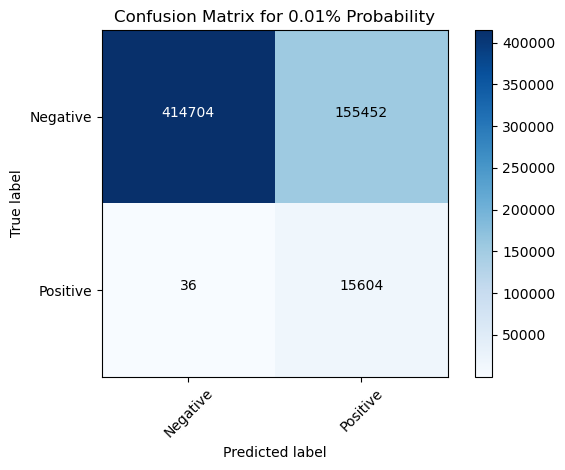

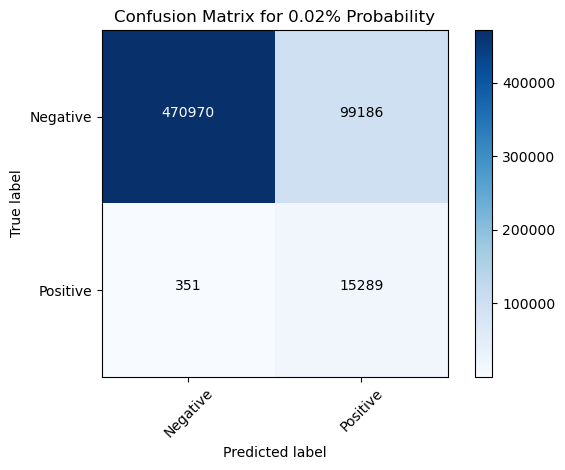

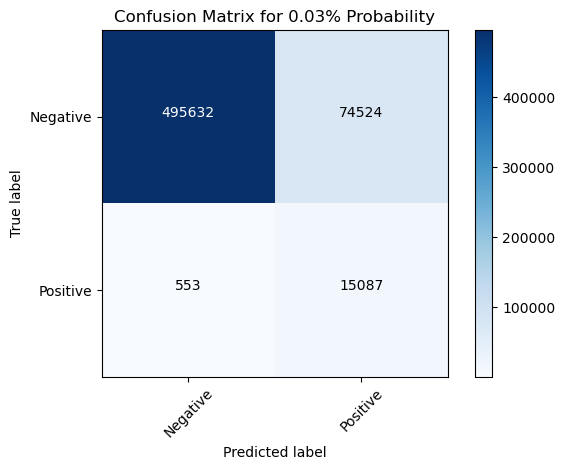

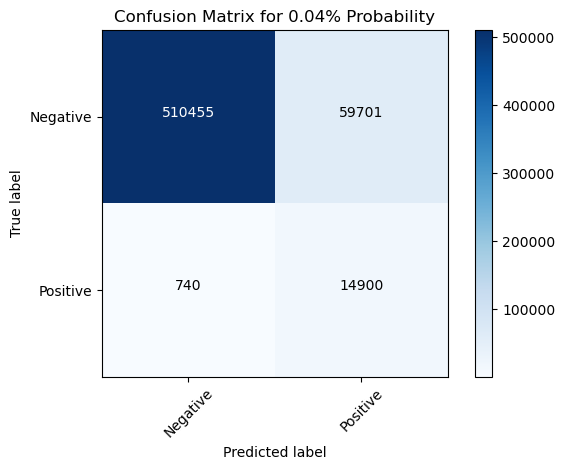

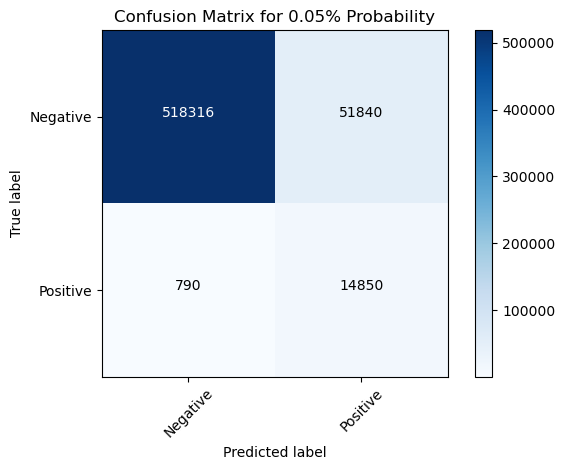

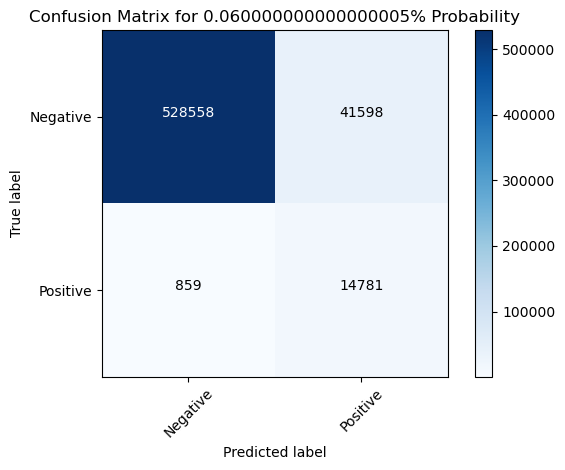

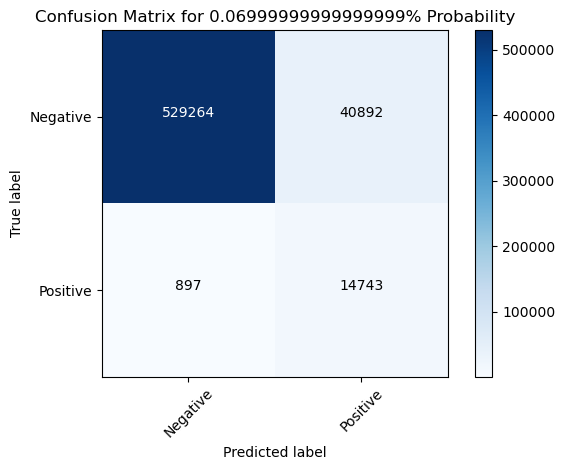

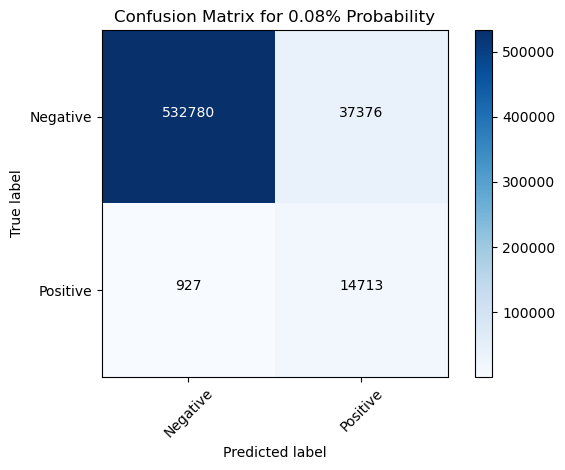

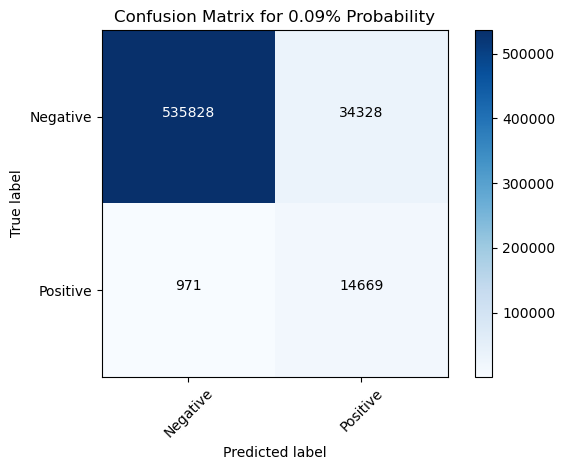

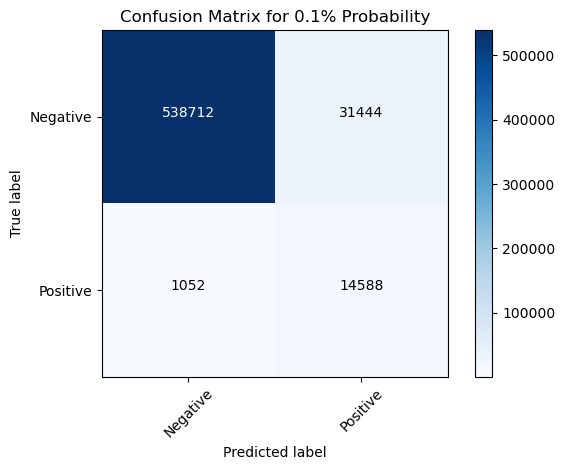

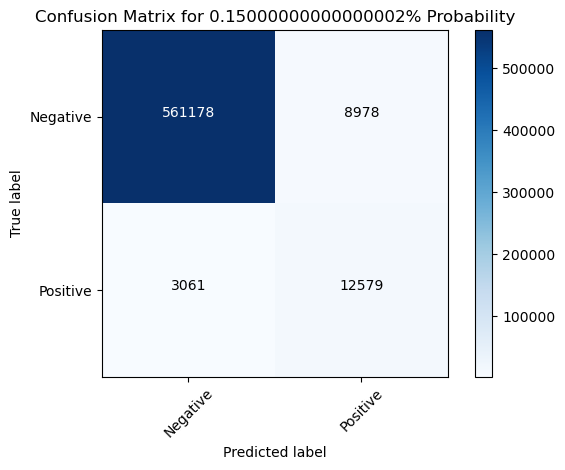

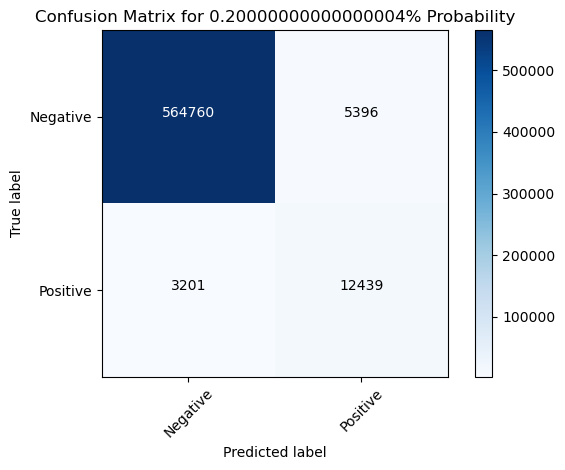

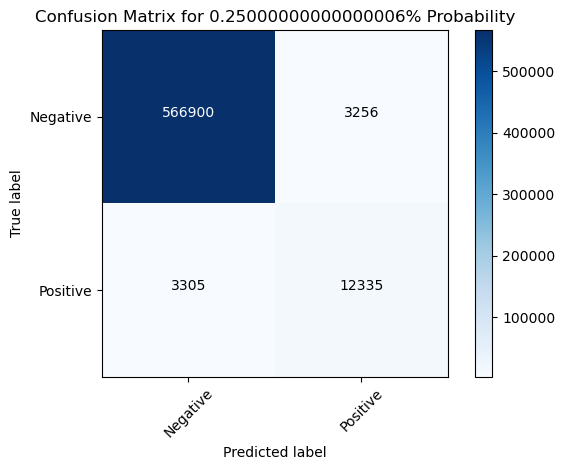

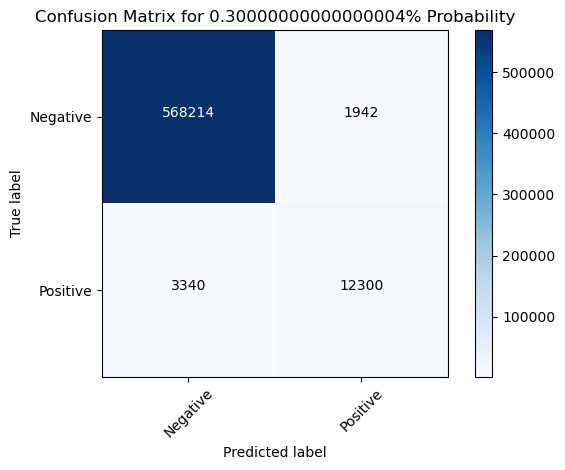

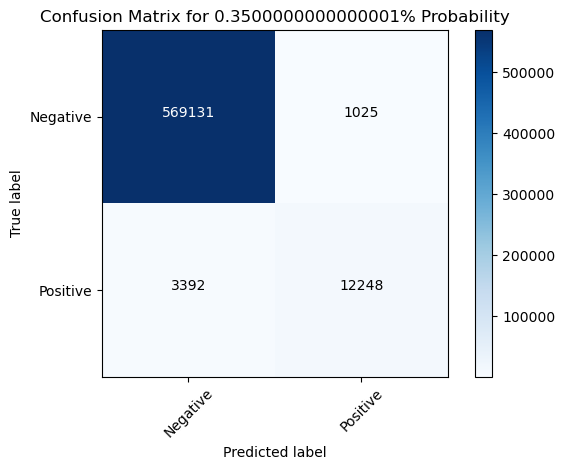

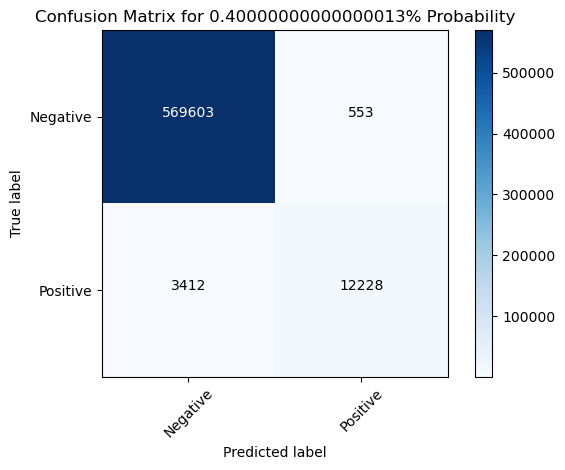

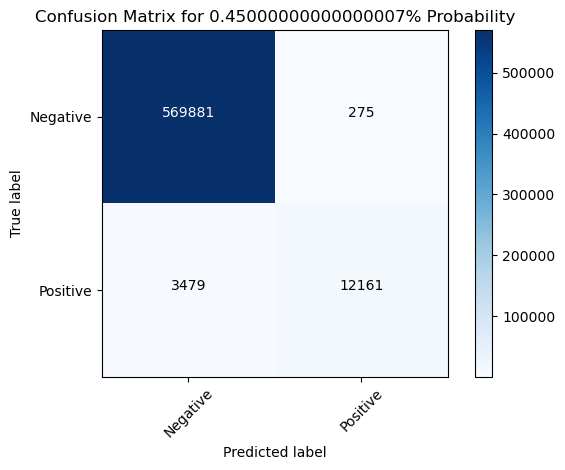

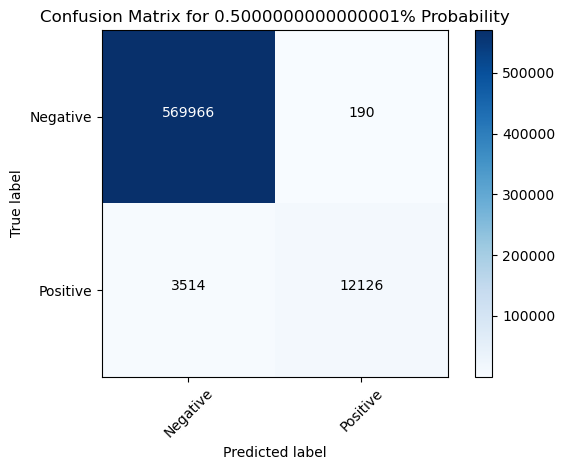

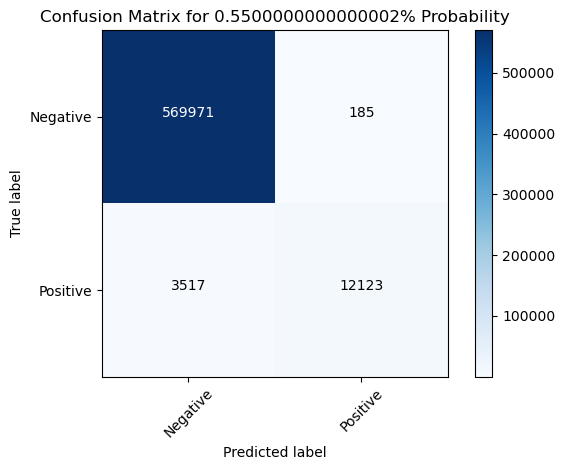

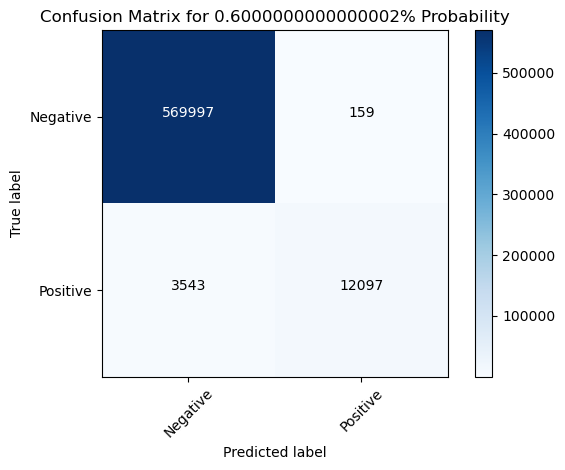

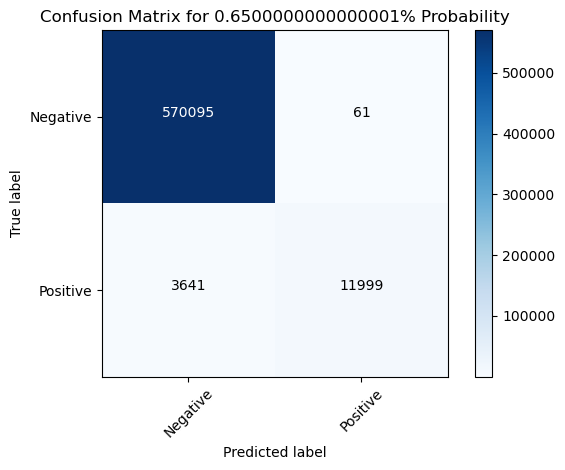

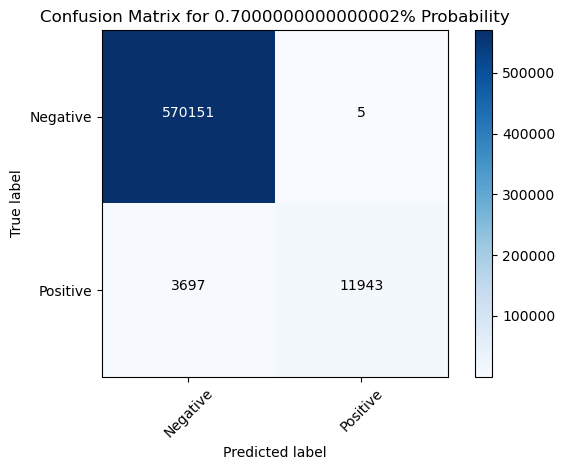

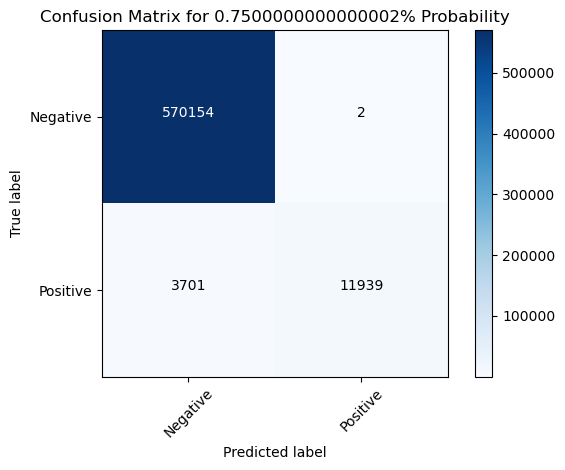

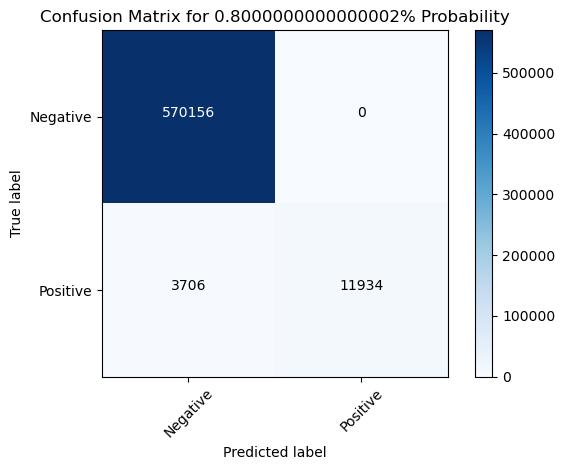

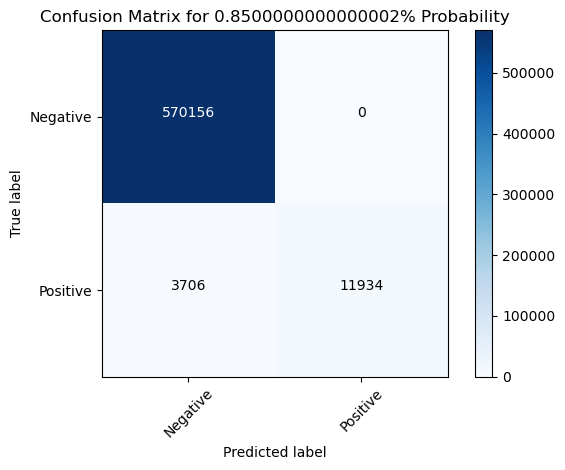

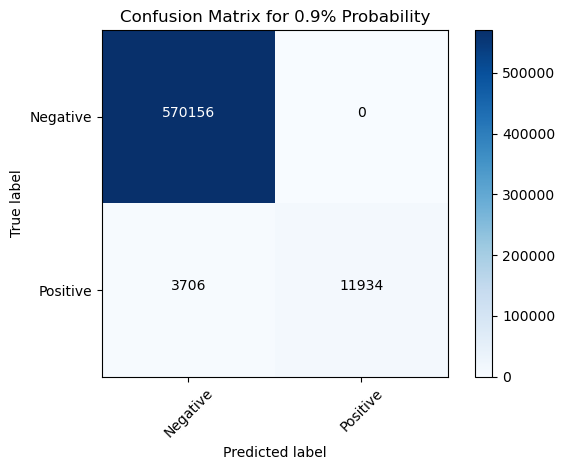

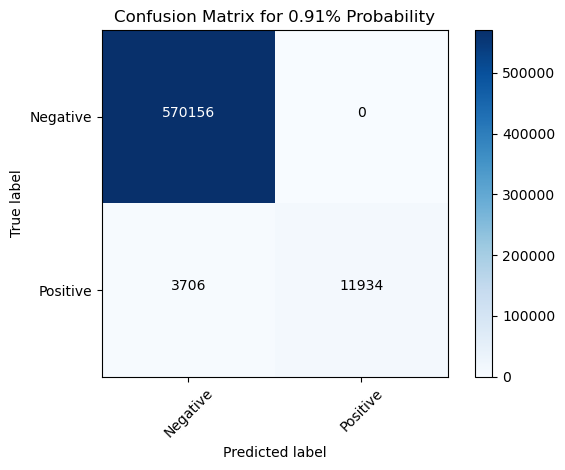

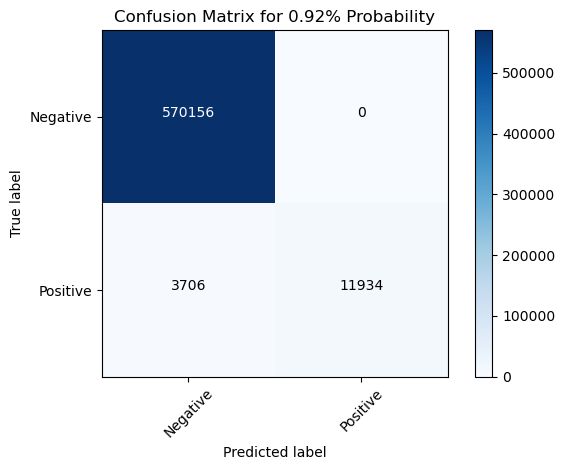

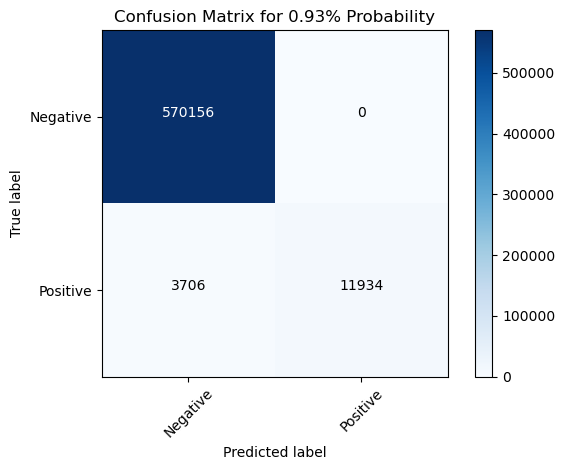

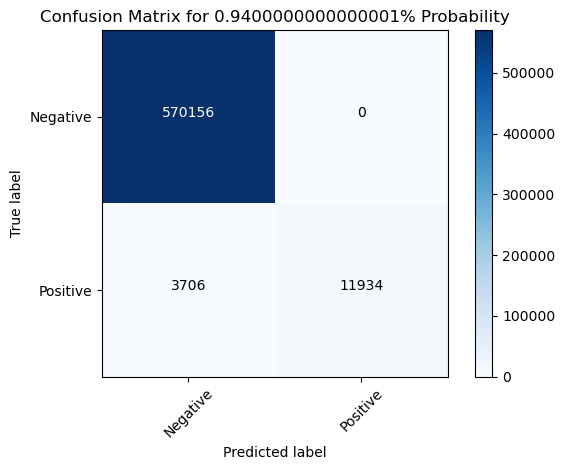

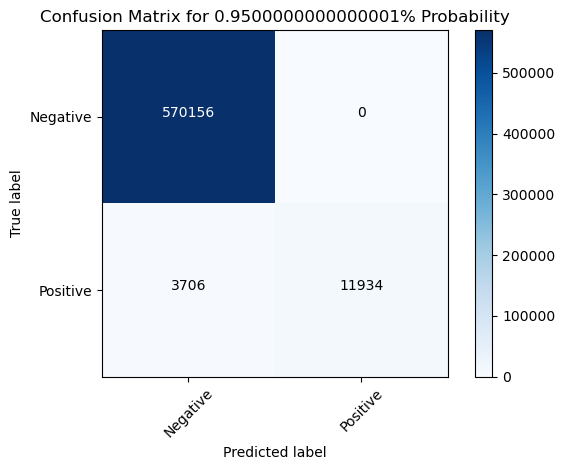

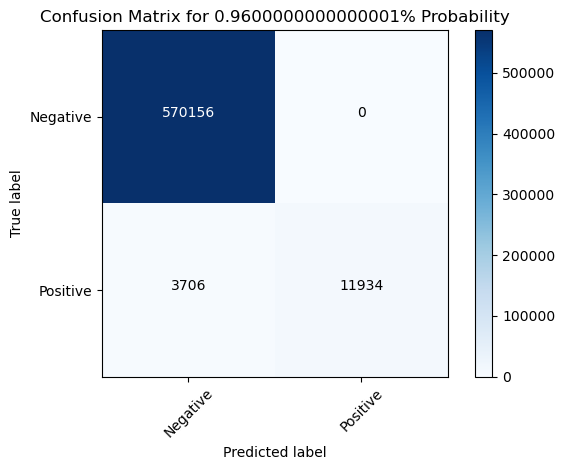

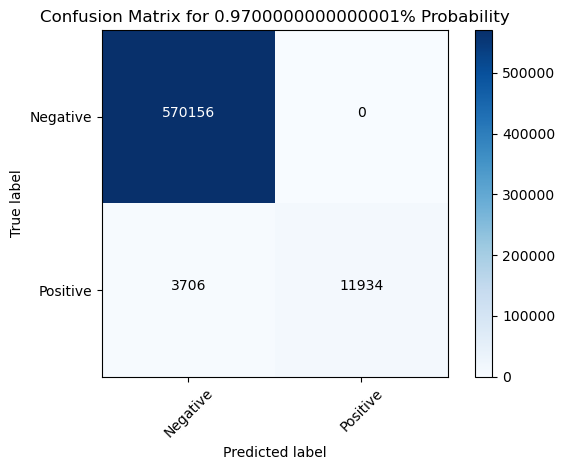

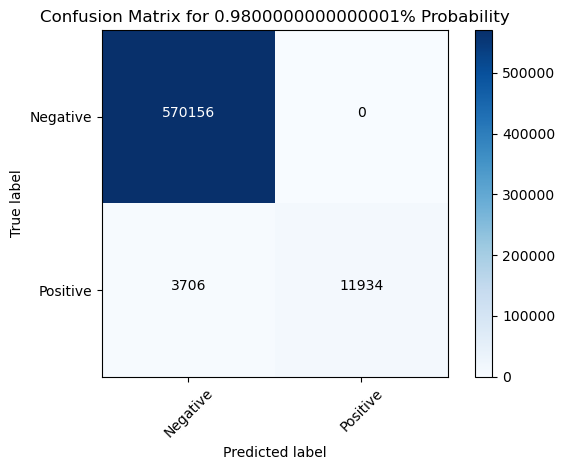

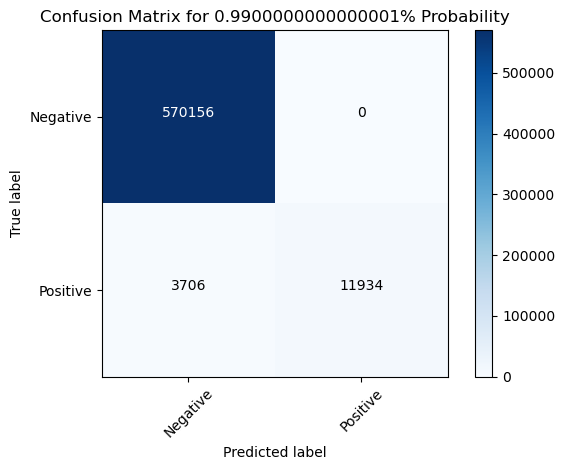

In [120]:
for idx in range(len(thresh_arrays)):
    conf_matrix = confusion_matrix(y, thresh_arrays[idx])

    # Plot confusion matrix
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {thresholds[idx]}% Probability')
    plt.colorbar()
    
    # Add labels
    classes = ['Negative', 'Positive'] 
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Add text annotations
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [136]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix

In [121]:
accuracies = np.zeros(len(thresholds))
precisions = np.zeros(len(thresholds))
f1s = np.zeros(len(thresholds))
rocs = np.zeros(len(thresholds))
prs = np.zeros(len(thresholds))
recalls = np.zeros(len(thresholds))

In [122]:
for idx in range(len(thresholds)):
    accuracies[idx] = accuracy_score(y, thresh_arrays[idx])
    precisions[idx] = precision_score(y, thresh_arrays[idx])
    f1s[idx] = f1_score(y, thresh_arrays[idx])
    rocs[idx] = roc_auc_score(y, thresh_arrays[idx])
    prs[idx] = average_precision_score(y, thresh_arrays[idx])
    recalls[idx] = recall_score(y, thresh_arrays[idx])

Text(0.5, 1.0, 'Score at Various Probability Thresholds')

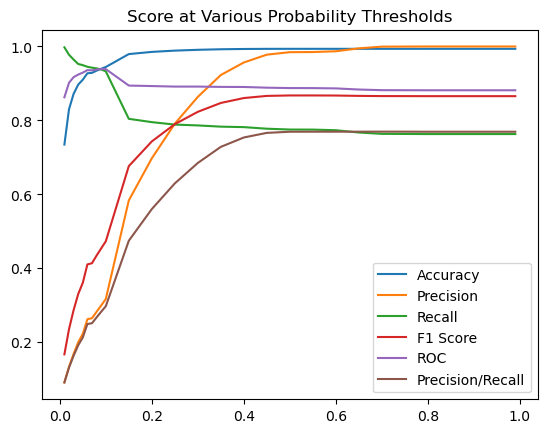

In [123]:
plt.figure()
plt.plot(thresholds, accuracies, label='Accuracy')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1 Score')
plt.plot(thresholds, rocs, label='ROC')
plt.plot(thresholds, prs, label='Precision/Recall')
plt.legend()
plt.title('Score at Various Probability Thresholds')

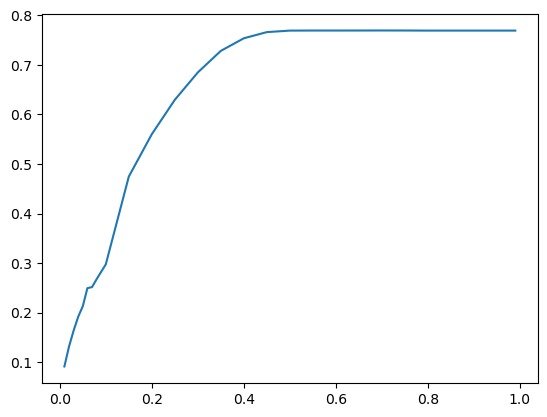

In [124]:
plt.plot(thresholds, prs, label='Precision/Recall')

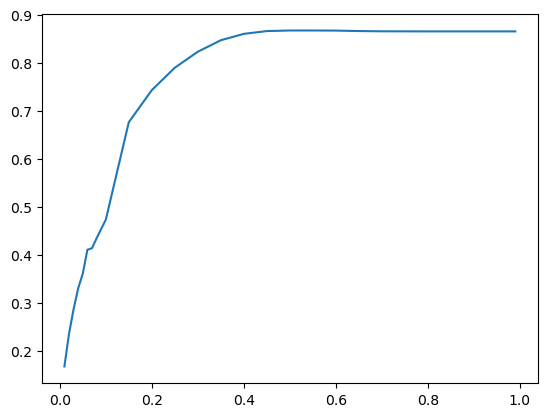

In [125]:
plt.plot(thresholds, f1s, label='F1')

In [400]:
### SOMETHING TO LOOK AT NEXT TIME!!!

# tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

# positive_accuracy = tp / (tp + fn)
# negative_accuracy = tn / (tn + fp)

## Exploring Data Downsampling

We have three downsampling methods that we'll explore:
1. Marion's scientifically filtered dataset
2. Random Undersampling
3. Near Miss (version 1 in `imbalanced learn`)

We'll also try downsampling with the instance hardness threshold on the overall dataset to see if it does anything useful.

### Marion's Downsampled Set

In [76]:
#this is downloading the data
Bedforms_ds = pd.read_csv('data/TPI_processed.csv')
y_ds = Bedforms_ds['Y/N'] #results data that will be used to compare to the trained output
X_ds = Bedforms_ds[['Topo', 'Bed', 'Elong', 'Area']] #input data that will be used to train the results

#we are changing all string inputs to binarized integers so they can be processed by the model.
X_ds.loc[X_ds['Topo'] == 'O', 'Topo'] = 1
X_ds.loc[X_ds['Topo'] == 'V', 'Topo'] = 0

X_ds.loc[X_ds['Bed'] == 'C', 'Bed'] = 1
X_ds.loc[X_ds['Bed'] == 'S', 'Bed'] = 0

X_ds.dtypes

Topo       int64
Bed        int64
Elong    float64
Area     float64
dtype: object

In [77]:
X_ds['Area']

0         29252.48555
1         49649.28231
2         52664.83314
3         59458.09575
4         32073.07100
             ...     
38066    313643.87180
38067     94168.17722
38068    629191.46660
38069    291092.35150
38070     95334.19987
Name: Area, Length: 38071, dtype: float64

We'll run just a standard random forest on these, and then we can redo the model selection to see if it makes a difference.

In [78]:
rf_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=5, 
                                  min_samples_split=150, random_state=42, n_jobs=-1) #using all 4 cpus
rf_model.fit(X_ds, y_ds)

RandomForestClassifier(min_samples_leaf=5, min_samples_split=150, n_jobs=-1,
                       random_state=42)

In [79]:
y_ds_est = rf_model.predict(X_ds)

In [80]:
print(f'Prediction Count: {len(y_ds_est)}')
print(f'Correct Predictions: {len(y_ds_est[y_ds_est == y_ds])}')

Prediction Count: 38071
Correct Predictions: 33561


In [81]:
33561/38071

0.8815371279976886

In [83]:
print('acc: ', accuracy_score(y_ds, y_ds_est))
print('precision: ', precision_score(y_ds, y_ds_est))
print('f1: ',f1_score(y_ds, y_ds_est))
# print('roc: ', roc_auc_score(y_ds, y_ds_est))
# print('av_prec: ', average_precision_score(y_ds, y_ds_est))
print('recall: ', recall_score(y_ds, y_ds_est))

acc:  0.8815371279976886
precision:  0.7742379547689282
f1:  0.6358204134366925
recall:  0.5393889573914235


In [84]:
conf_matrix = confusion_matrix(y_ds, y_ds_est)

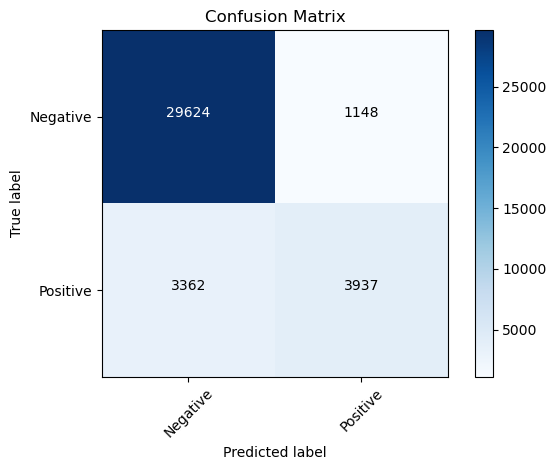

In [85]:
# Plot confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels
classes = ['Negative', 'Positive']  # Assuming class names
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add text annotations
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

Now try this with the barely balanced random forest.

In [86]:
len(y_ds[y_ds == 1])/len(y_ds)

0.191720732315936

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X_ds, y_ds, test_size=0.33, random_state=42)

In [124]:
brf_classifier = BalancedRandomForestClassifier(sampling_strategy=0.24, replacement=True, 
                                                random_state=42, bootstrap=False)

In [125]:
brf_classifier.fit(X_train, y_train)

BalancedRandomForestClassifier(bootstrap=False, random_state=42,
                               replacement=True, sampling_strategy=0.24)

In [126]:
y_pred_prob = brf_classifier.predict_proba(X_test)

In [132]:
def thresh(array, threshold):
    col = array[:,1]
    mod_array = np.copy(col)
    mod_array[mod_array >= threshold] = 1
    mod_array[mod_array < threshold] = 0
    
    return mod_array

In [128]:
y_pred = thresh(y_pred_prob, 0.65)

In [129]:
conf_matrix = confusion_matrix(y_test, y_pred)

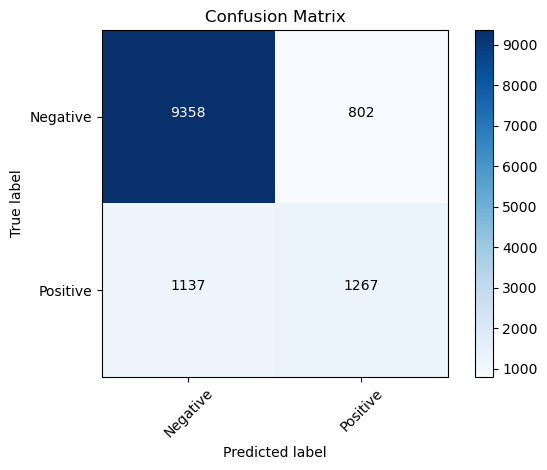

In [130]:
# Plot confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels
classes = ['Negative', 'Positive']  # Assuming class names
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add text annotations
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [133]:
thresholds = np.concatenate((np.arange(0.01,0.1,0.01), np.arange(0.1,0.9,0.05), np.arange(0.9,1,0.01)))
thresh_arrays = np.zeros((len(thresholds),len(y_pred_prob)))

for idx in range(len(thresh_arrays)):
    thresh_arrays[idx] =  thresh(y_pred_prob, thresholds[idx])

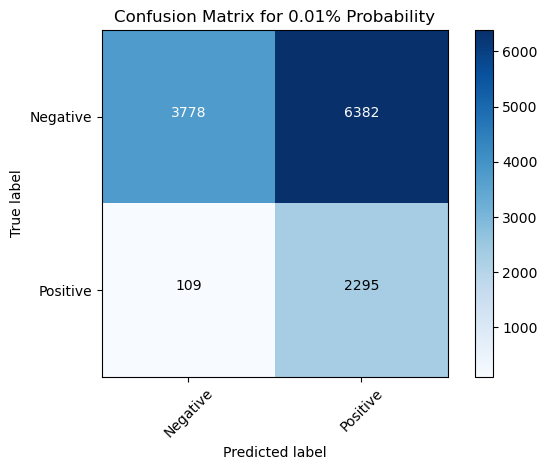

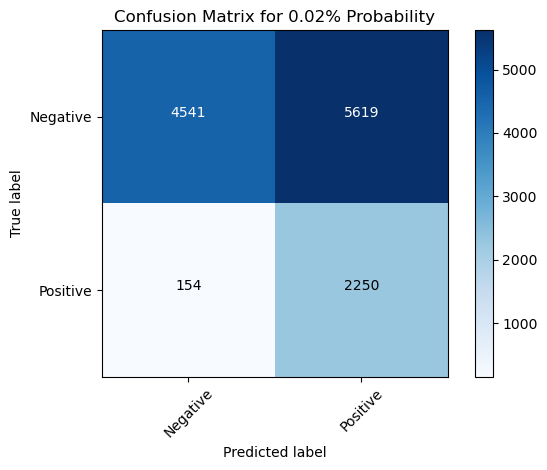

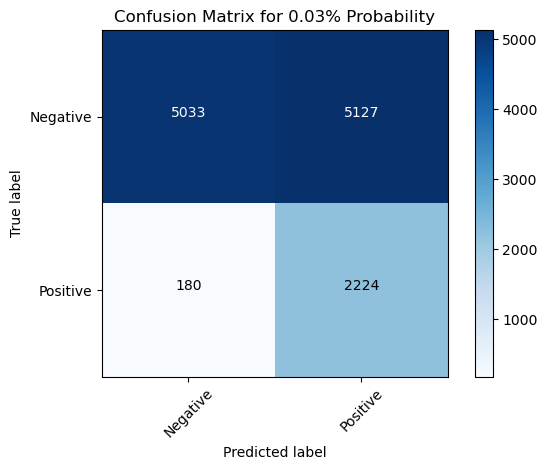

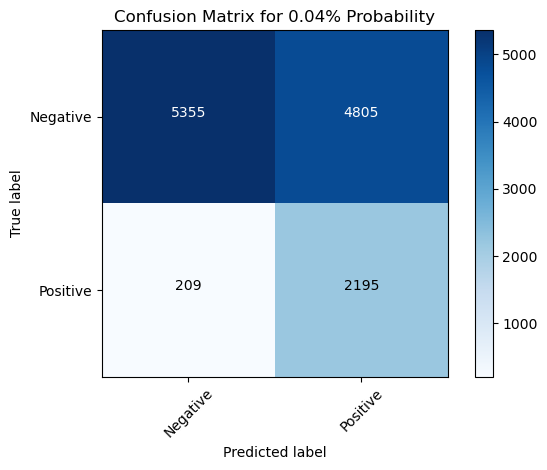

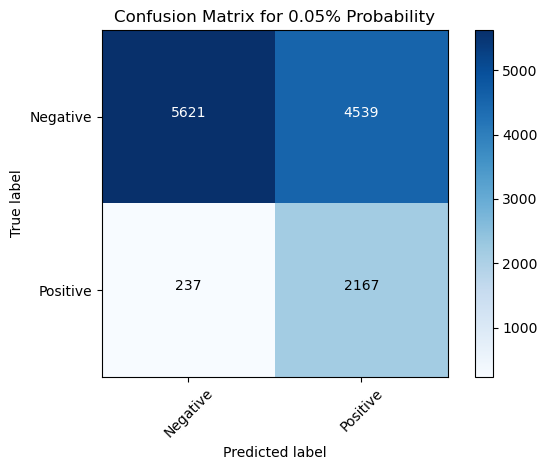

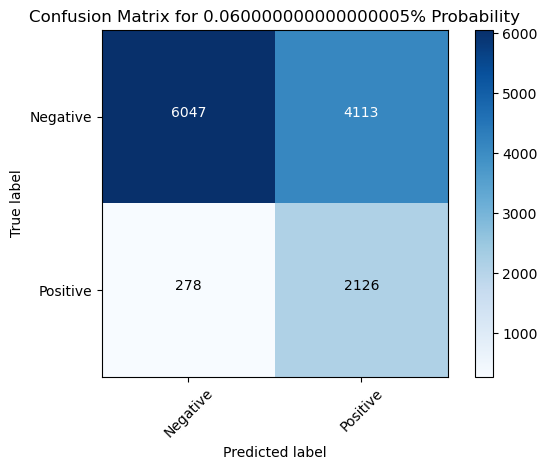

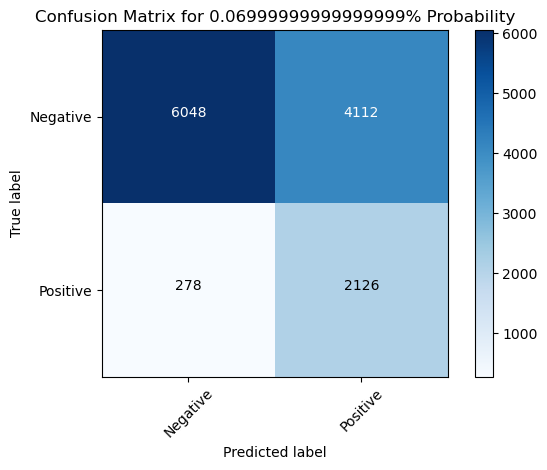

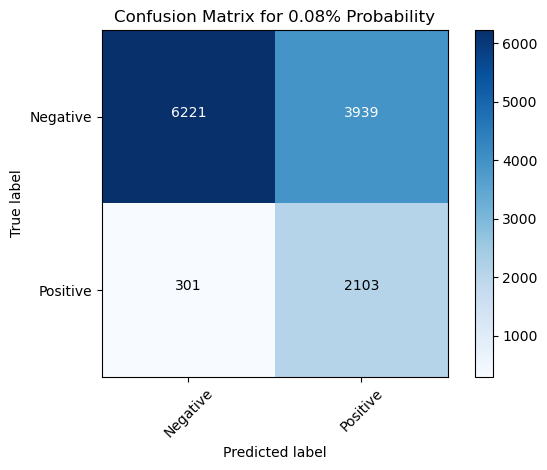

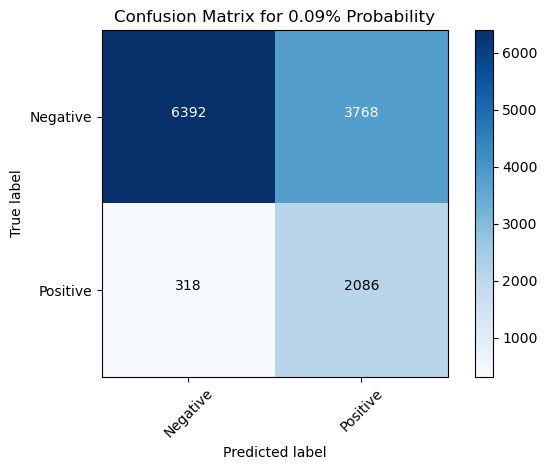

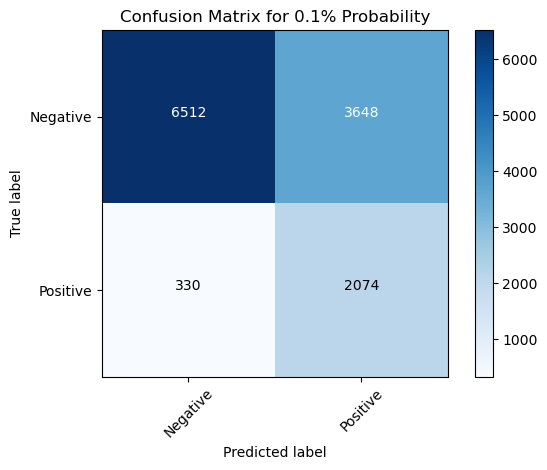

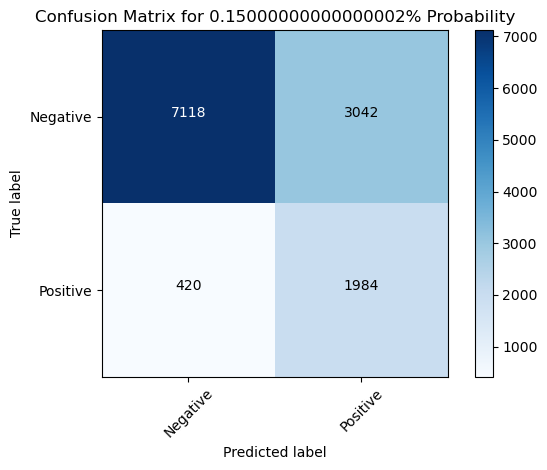

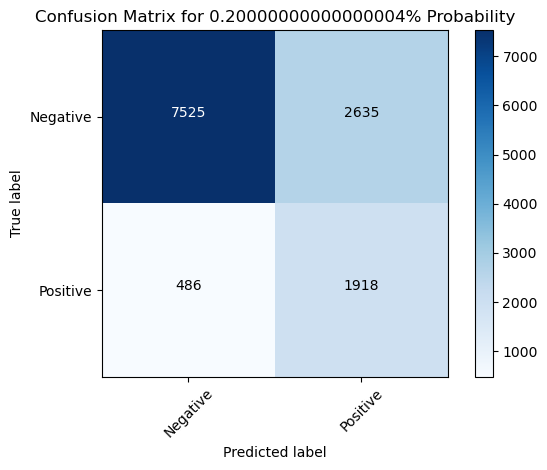

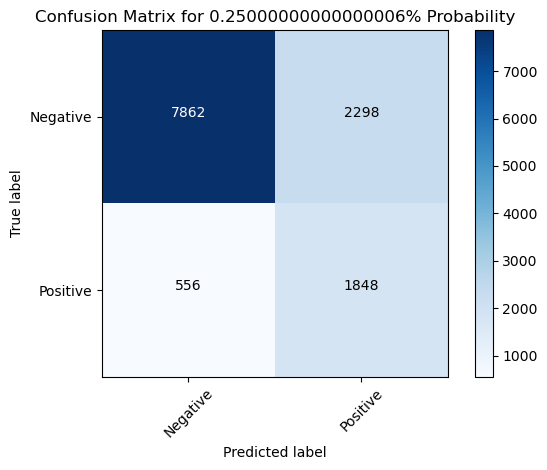

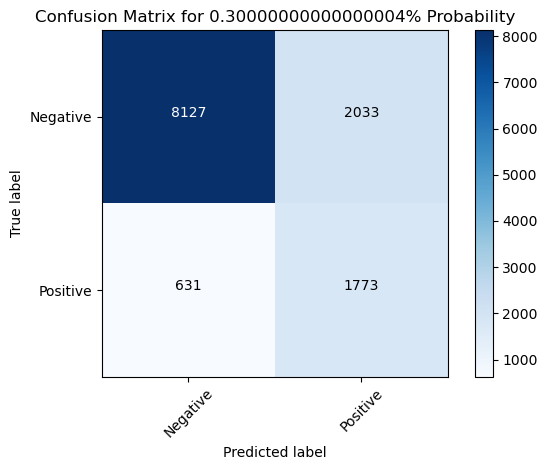

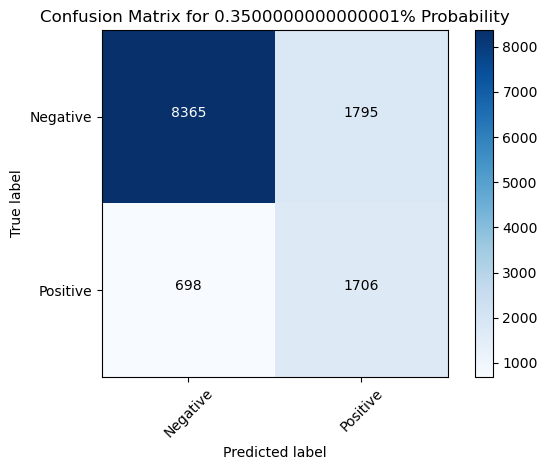

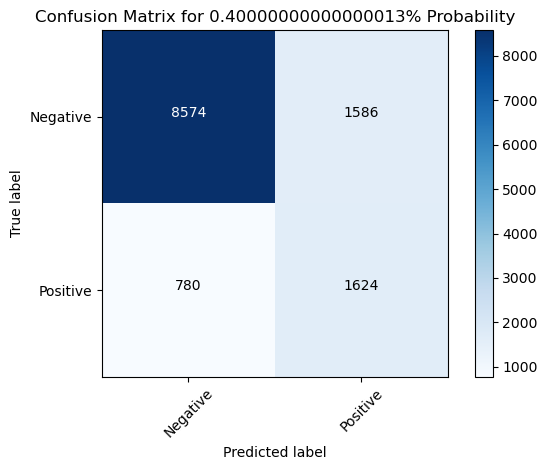

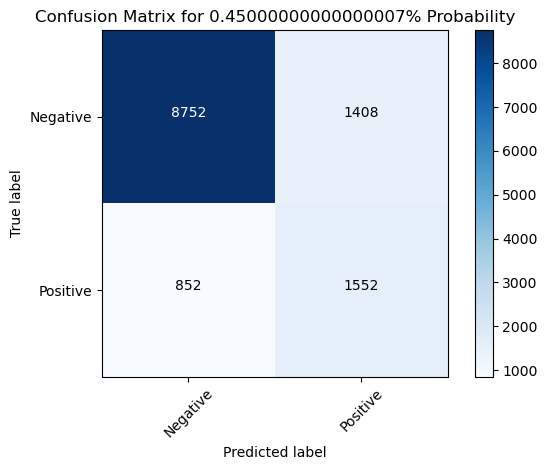

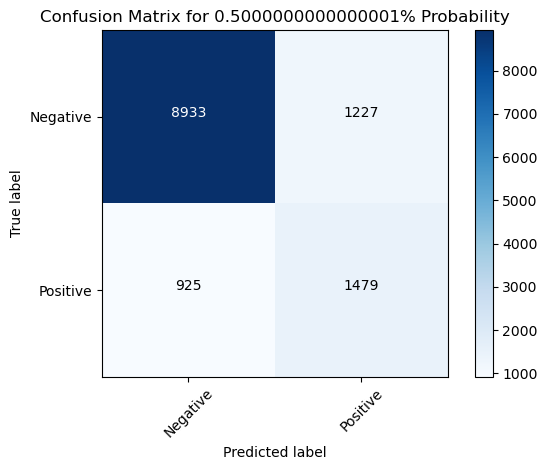

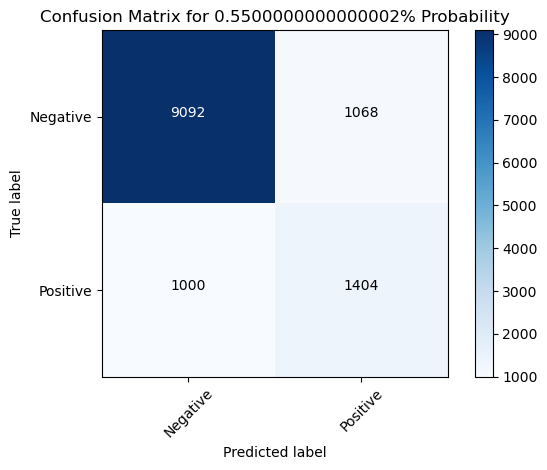

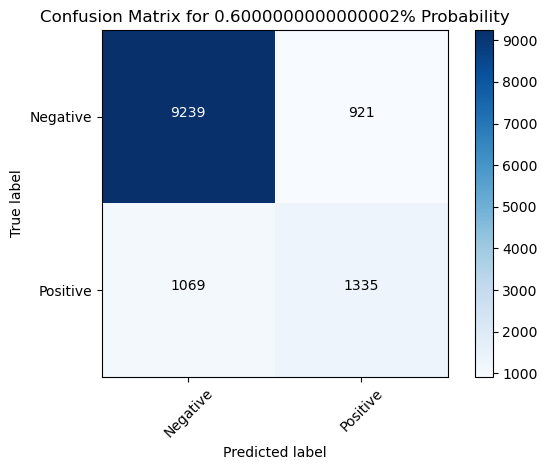

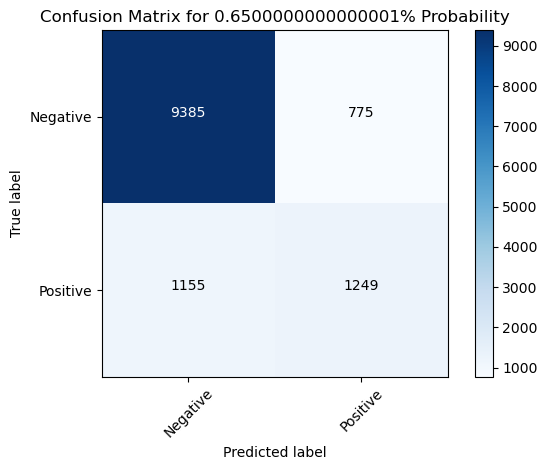

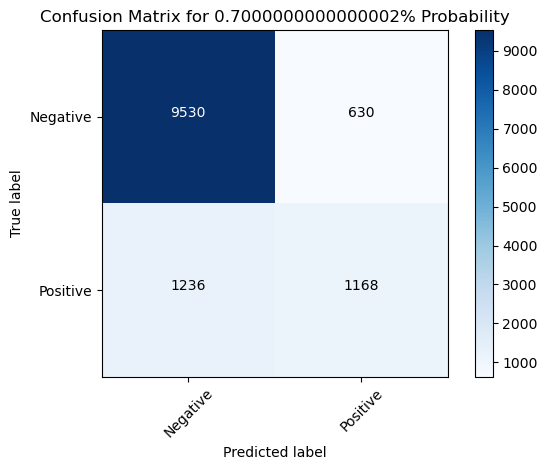

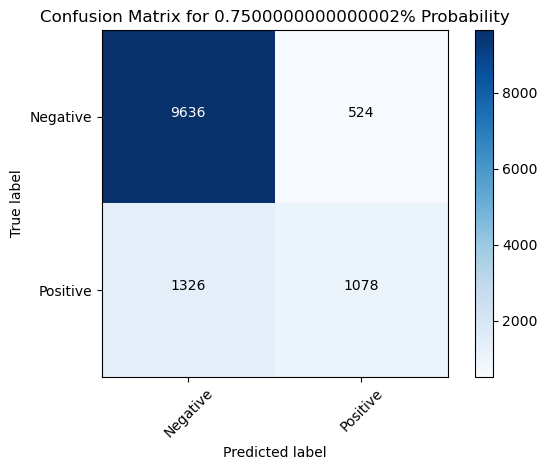

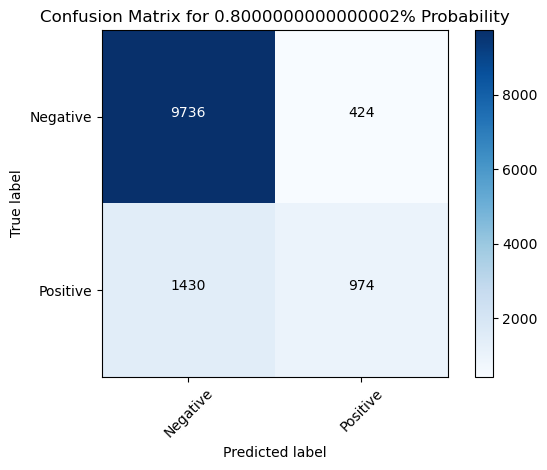

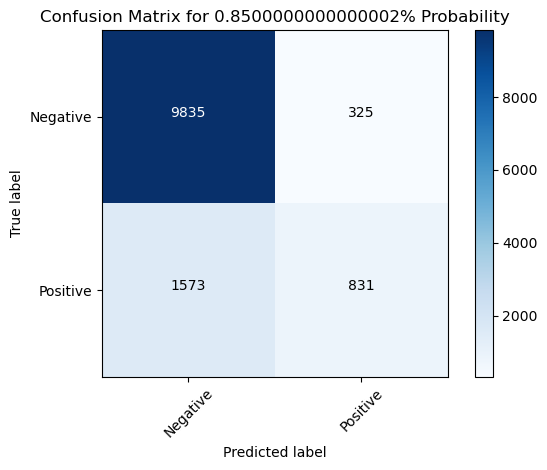

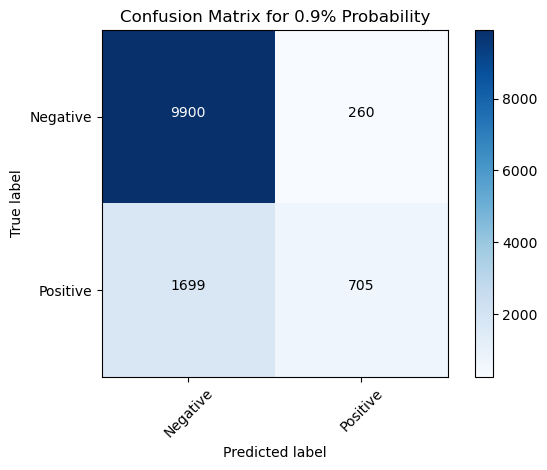

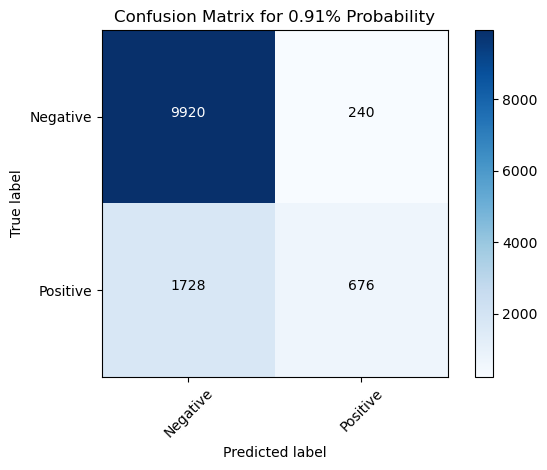

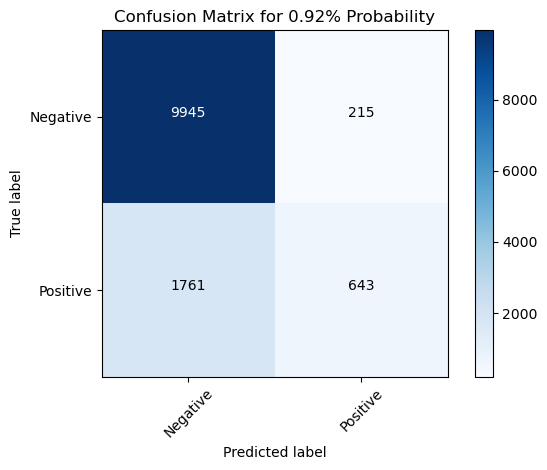

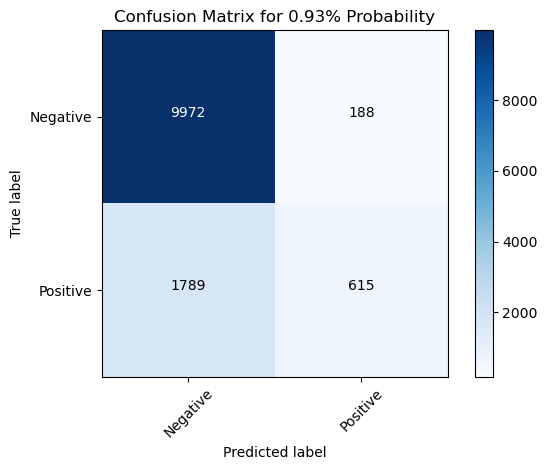

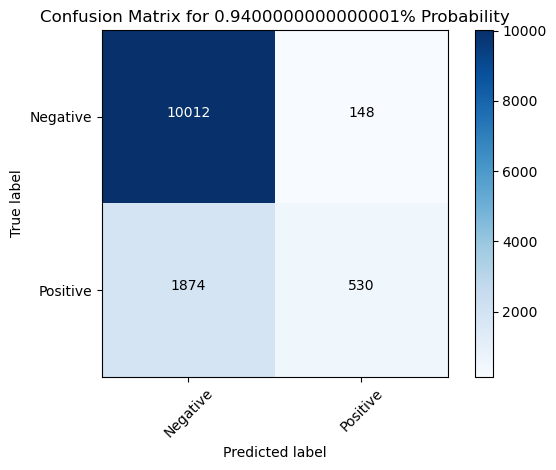

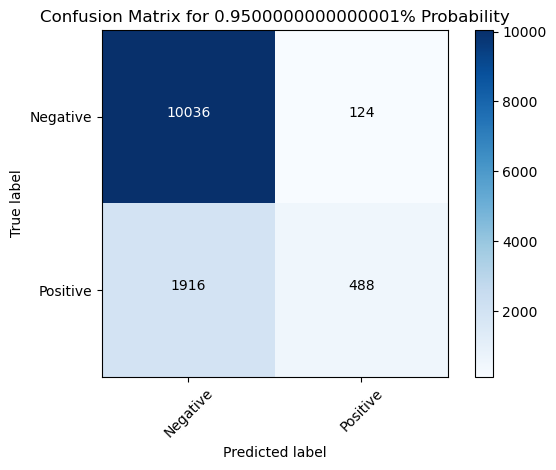

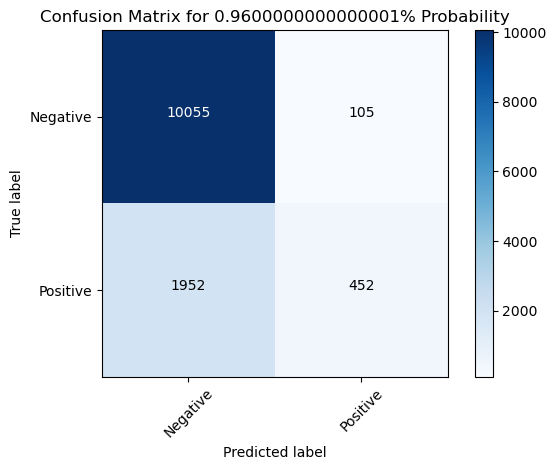

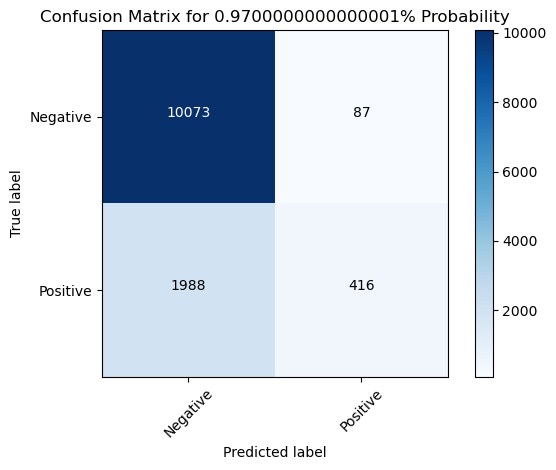

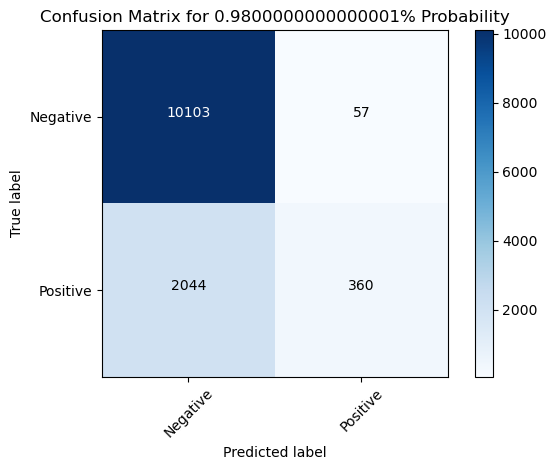

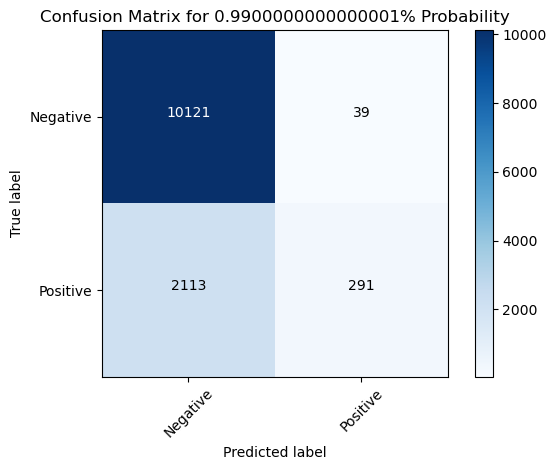

In [135]:
for idx in range(len(thresh_arrays)):
    conf_matrix = confusion_matrix(y_test, thresh_arrays[idx])

    # Plot confusion matrix
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {thresholds[idx]}% Probability')
    plt.colorbar()
    
    # Add labels
    classes = ['Negative', 'Positive'] 
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Add text annotations
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [138]:
accuracies = np.zeros(len(thresholds))
precisions = np.zeros(len(thresholds))
f1s = np.zeros(len(thresholds))
rocs = np.zeros(len(thresholds))
prs = np.zeros(len(thresholds))
recalls = np.zeros(len(thresholds))

for idx in range(len(thresholds)):
    accuracies[idx] = accuracy_score(y_test, thresh_arrays[idx])
    precisions[idx] = precision_score(y_test, thresh_arrays[idx])
    f1s[idx] = f1_score(y_test, thresh_arrays[idx])
    rocs[idx] = roc_auc_score(y_test, thresh_arrays[idx])
    prs[idx] = average_precision_score(y_test, thresh_arrays[idx])
    recalls[idx] = recall_score(y_test, thresh_arrays[idx])

Text(0.5, 1.0, 'Score at Various Probability Thresholds')

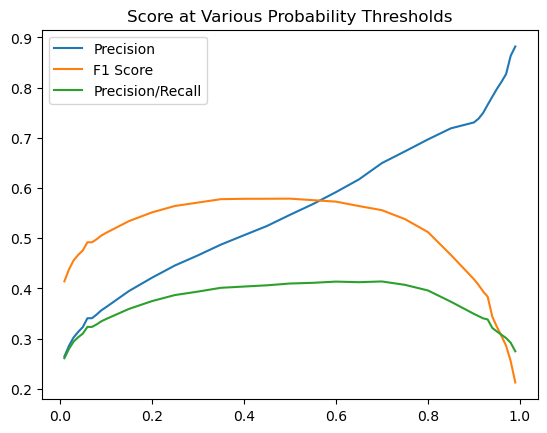

In [140]:
plt.figure()
# plt.plot(thresholds, accuracies, label='Accuracy')
plt.plot(thresholds, precisions, label='Precision')
# plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1 Score')
# plt.plot(thresholds, rocs, label='ROC')
plt.plot(thresholds, prs, label='Precision/Recall')
plt.legend()
plt.title('Score at Various Probability Thresholds')